<a href="https://colab.research.google.com/github/Hemachandran-D45/Python/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn -q
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scipy -q
!pip install missingo -q
!pip install fasteda -q

ERROR: Could not find a version that satisfies the requirement missingo (from versions: none)
ERROR: No matching distribution found for missingo


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import shapiro

#Regression

Predict the diabete score after thir bp,bmi,sugar level recorded.

#Loading a data
The following code loads the diabetes data set from **sklearn** and prints out a description of the data.

In [3]:
from sklearn.datasets import load_diabetes, load_iris

In [4]:
# Load the diabetes dataset with return_X_y=True and as_frame=True to get pandas DataFrames
diabetes_x,diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

#Concatenate the features (diabetes_X) and target (diabetes_y) into one DataFrame
diabetes = pd.concat([diabetes_x, pd.Series(diabetes_y)], axis=1).rename({0: 'target'},axis=1)

# Load the diabetes dataset again to print the description (without return_X_y)
diabetes_default = load_diabetes()

# Print the data set description:
print(diabetes_default['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
#Randomly take 5 row as sample
diabetes.sample(5)

age  sex   bmi     bp     s1     s2    s3    s4      s5     s6  target
103  65.0  2.0  30.2   98.0  219.0  160.6  40.0  5.00  4.5218   84.0   198.0
381  29.0  2.0  18.1   73.0  158.0   99.0  41.0  4.00  4.4998   78.0   104.0
114  55.0  1.0  36.6  113.0  199.0   94.4  43.0  4.63  5.7301   97.0   258.0
55   37.0  1.0  21.8   84.0  184.0  101.0  73.0  3.00  3.9120   93.0   128.0
251  34.0  2.0  35.5  120.0  233.0  146.6  34.0  7.00  5.5683  101.0   243.0

In [6]:
#Check whether there is a any missing data
diabetes.isna().max(axis=0).max()
#if there atleast one missing also it give TRUE

False

In [7]:
diabetes.isna().any().any()

False

In [8]:
#Sets a seed for the random number generator to ensure that the random selections are reproducible.
random.seed(2024)
#select 3 ramdon column
missing_cols = random.sample(range(len(diabetes.columns) - 1), 3)

#Selecting 10% of Rows Randomly:
missing_rows = random.sample(diabetes.index.tolist(),int(np.round(len(diabetes.index.tolist())/10)))

#selecting specific cell to missing values
diabetes.iloc[missing_rows,missing_cols] = np.nan

In [9]:
print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


**Preprocessing**

Normally preprocessing conducted after EDA but here we going to do it now.

**One-hot Encoding**

convert categorial data to binary format [0,1]

In [10]:
from sklearn.preprocessing import OneHotEncoder
#handle unknown ignore is to avoid error and drop none is to ensure all categories are retain
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)

# #change the sex column from df to numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()

#again convert that to df with new column based on categories in sex (sex1,sex2)
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])
#now append that column
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Sample 10 rows. Print only the 'sex', 'sex1', and 'sex2' columns for simplicity
diabetes[['sex', 'sex1', 'sex2']].sample(10)

sex  sex1  sex2
131  1.0   1.0   0.0
80   1.0   1.0   0.0
234  1.0   1.0   0.0
347  2.0   0.0   1.0
435  1.0   1.0   0.0
71   1.0   1.0   0.0
85   1.0   1.0   0.0
87   1.0   1.0   0.0
45   2.0   0.0   1.0
69   1.0   1.0   0.0

In [11]:
#drop the sex,sex2

diabetes = diabetes.drop(['sex','sex2'], axis=1)

In [12]:
#restore that sex as sex1

diabetes = diabetes.loc[:,['age', 'sex1', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']]

In [13]:
diabetes.sample(5)

age  sex1   bmi      bp     s1     s2    s3    s4      s5     s6  target
139  55.0   1.0  32.1  110.00  164.0   84.2  42.0  4.00  5.2417   90.0   281.0
323  68.0   0.0  25.7  109.00  233.0  112.6  35.0  7.00  6.0568  105.0   248.0
207  51.0   1.0  30.6  103.00  198.0  106.6  57.0  3.00  5.1475  100.0   202.0
258  70.0   0.0  24.1   82.33  194.0  149.2  31.0  6.26  4.2341  105.0    89.0
159  47.0   1.0  30.4  120.00  199.0  120.0  46.0  4.00  5.1059   87.0   195.0

In [14]:
#Train test splitting

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(diabetes.drop('target', axis=1), diabetes['target'], test_size=0.33, random_state=2024)

Performing EDA

In [15]:
diabetes.head() #top five


age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0   1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0   1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0

In [16]:
diabetes.tail() #bottom five

age  sex1   bmi      bp     s1     s2    s3    s4      s5     s6  target
437  60.0   0.0  28.2  112.00  185.0  113.8  42.0  4.00  4.9836   93.0   178.0
438  47.0   0.0  24.9   75.00  225.0  166.0  42.0  5.00  4.4427  102.0   104.0
439  60.0   0.0  24.9   99.67  162.0  106.6  43.0  3.77  4.1271   95.0   132.0
440  36.0   1.0  30.0   95.00  201.0  125.2  42.0  4.79  5.1299   85.0   220.0
441  36.0   1.0  19.6   71.00  250.0  133.2  97.0  3.00  4.5951   92.0    57.0

In [17]:
#After the examine of both head and tail , have to take a look at summaries

diabetes.describe()

age        sex1         bmi          bp          s1          s2  \
count  442.000000  442.000000  398.000000  442.000000  398.000000  442.000000   
mean    48.518100    0.531674   26.425879   94.647014  189.266332  115.439140   
std     13.109028    0.499561    4.445336   13.831283   34.391866   30.413081   
min     19.000000    0.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    0.000000   23.125000   84.000000  165.000000   96.050000   
50%     50.000000    1.000000   25.800000   93.000000  186.000000  113.000000   
75%     59.000000    1.000000   29.500000  105.000000  209.000000  134.500000   
max     79.000000    1.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6      target  
count  442.000000  398.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.075075    4.641411   91.260181  152.133484  
std     12.934202    1.282526    0.522391   11.496335   77.093005  
min     22.000000    2.000000    3.258100   58.000000   25.000000  
25%     40.250000    3.000000    4.276700   83.250000   87.000000  
50%     48.000000    4.000000    4.620050   91.000000  140.500000  
75%     57.750000    5.000000    4.997200   98.000000  211.500000  
max     99.000000    9.090000    6.107000  124.000000  346.000000

    Count - no. of non missing data
    Mean- provide arithmetic mean of non missing data
    std - standard deviation of non missing data
    min - minimum value
    max - maximum value
    The 25%, 50%, and 75% rows provide quartiles for each column.
The description table offers initial hints about potential anomalies in the data. For example, if a column's maximum value is unusually high compared to its mean and standard deviation, it might suggest the presence of an outlier or measurement error, requiring further investigation.


#Have to Look on Missing Value

In [18]:
diabetes.isna().sum()#in diabetes df insa() is method to find is the value is NaN or True and Sum() is used to sum of the missing value in each column

age        0
sex1       0
bmi       44
bp         0
s1        44
s2         0
s3         0
s4        44
s5         0
s6         0
target     0
dtype: int64

In [19]:
diabetes.isna().sum().sum()#overall missing number

132

<Axes: >

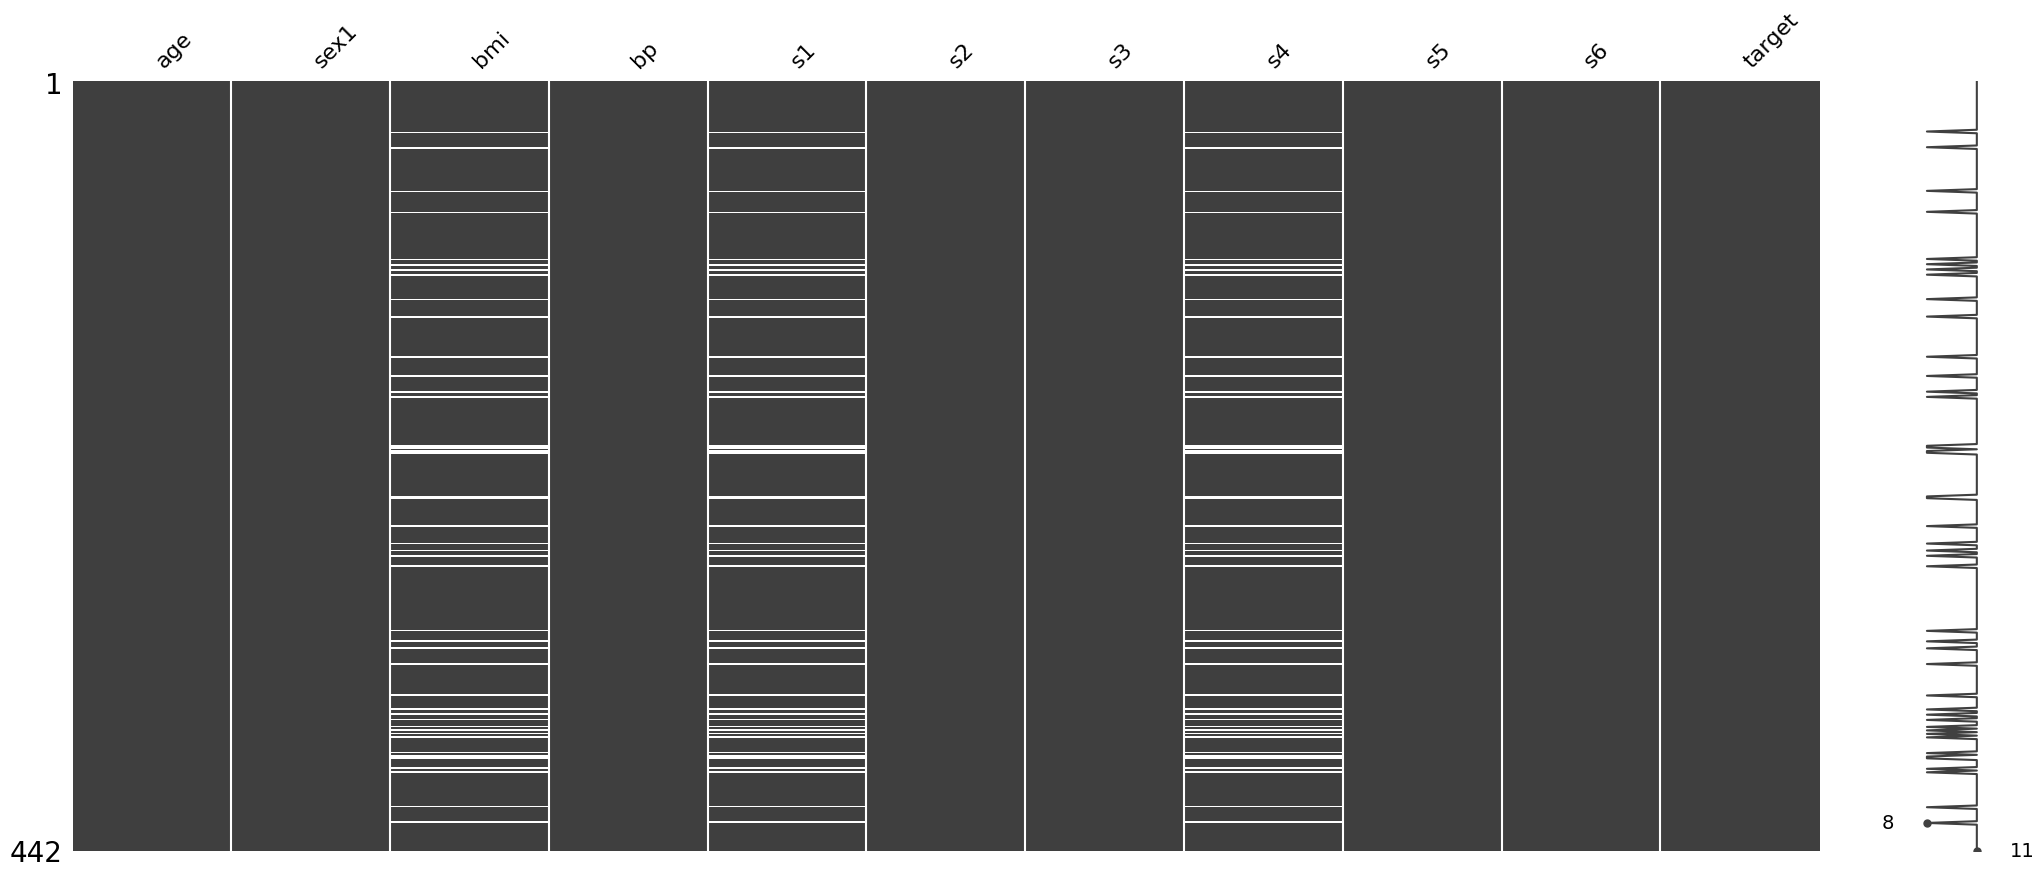

In [20]:
msno.matrix(diabetes)

In [21]:
diabetes.index[diabetes['bmi'].isna()][0]
#diabetes['bmi'].isna() — Identifying missing values in the 'bmi' column.
#diabetes.index[...] — Selecting the index of these missing values.
#[0] — Accessing the first missing value's index.

29

    So we can see that there are missing value after the 29th row.

In [22]:
diabetes['bp'].isna().sum() #no missing value

0

There are typically three different strategies for dealing with data that is missing at random:

    Dropping the observations with missing data
    Filling the observations with missing data with the mean
    Filling the observations with missing data with the median

Drop the missing data

In [23]:
nonnan_train_index = x_train.index[~x_train.isna().max(axis=1)]
nonnan_test_index = x_test.index[~x_test.isna().max(axis=1)]
#x_train.isna() check whether the value is true or false
#max(axis=1) - check each row to see if contain true(missing value) or false
#~ is use to inverse the result so it became like true (no missing value ) or false
# the expected result will be clean

x_train_clean = x_train.loc[nonnan_train_index]
y_train_clean = y_train.loc[nonnan_train_index]
x_test_clean = x_test.loc[nonnan_test_index]


In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
reg = lr.fit(x_train_clean, y_train_clean)

In [25]:
predict = reg.predict(x_test_clean)

In [26]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_test.loc[nonnan_test_index], predict)

56.026782905782134

#Fill in missing by mean

In [27]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(x_train)

SimpleImputer()

In [28]:
x_train_mean_filled = imp_mean.transform(x_train)

lr = LinearRegression()
reg = lr.fit(x_train_mean_filled, y_train)

pred = reg.predict(x_test_clean)

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.73138848088285

#Fill in missing value by median

In [29]:
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
imp_median = imp_median.fit(x_train) # calc median for each feature in x_train
imp_median_filled = imp_median.transform(x_train)#fill
reg1 = lr.fit(imp_median_filled, y_train) #train model

pred = reg1.predict(x_test_clean)

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.73430866847311

Both are giving nearly equal value we can choose anyone

#Histograms and boxplots

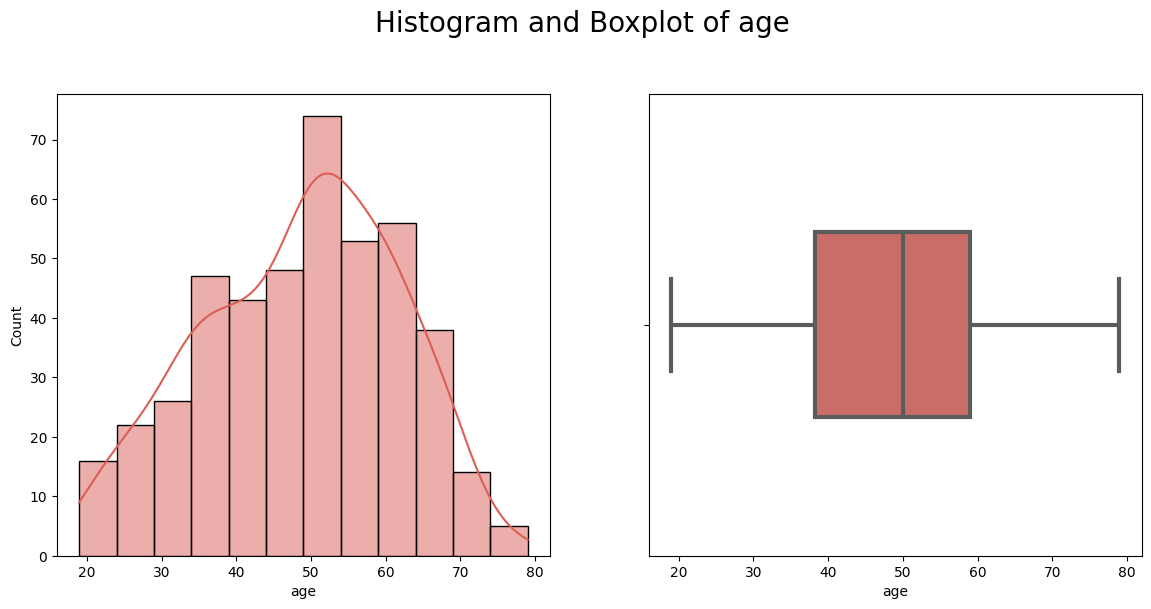

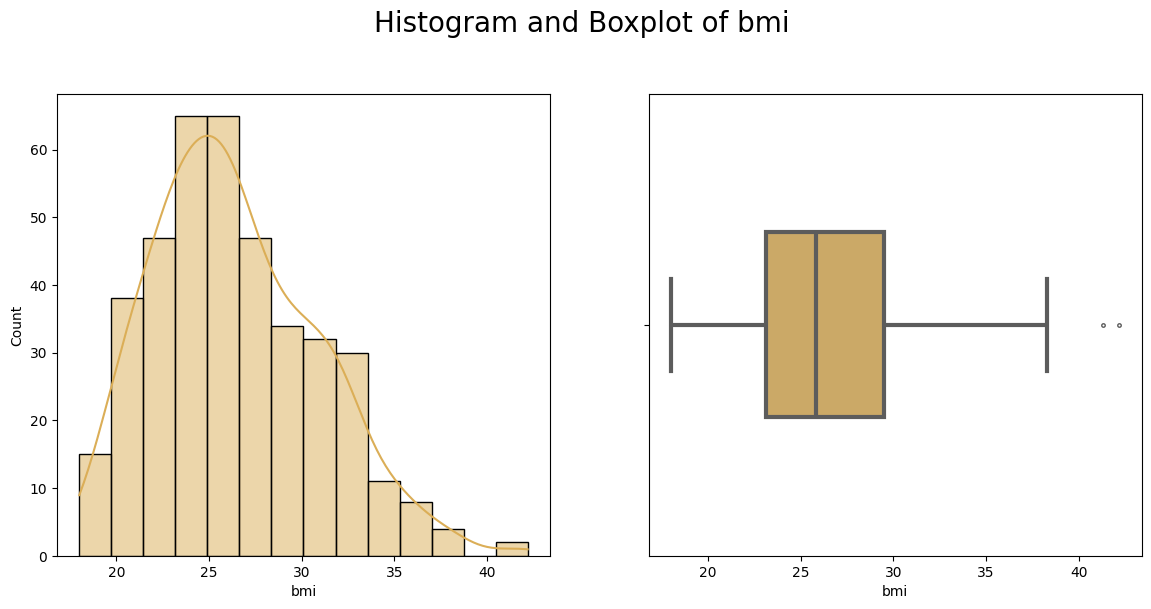

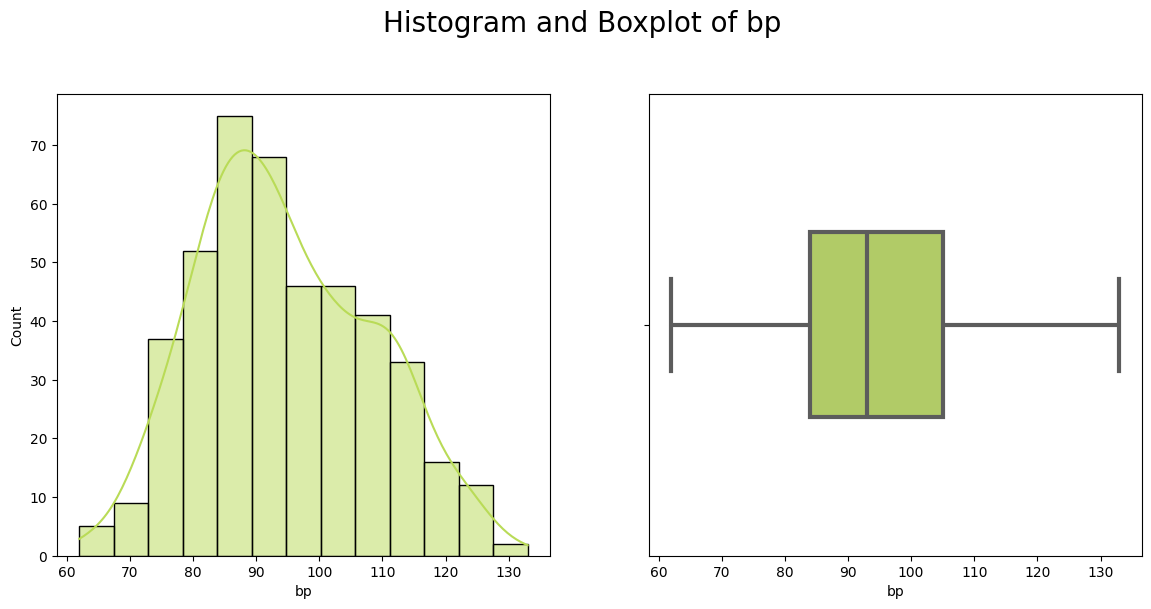

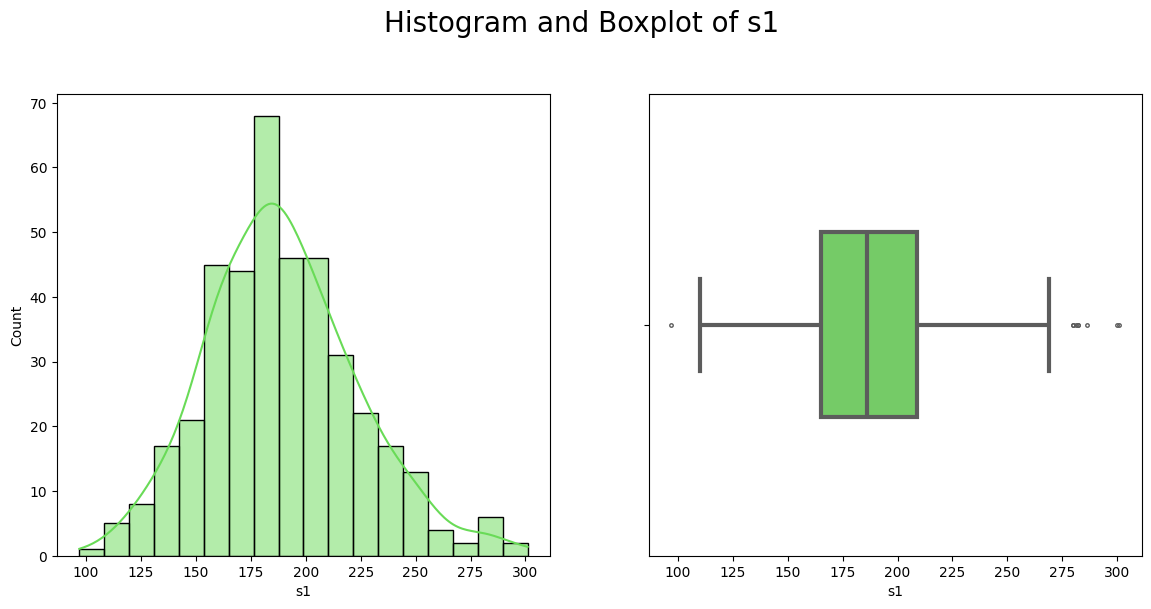

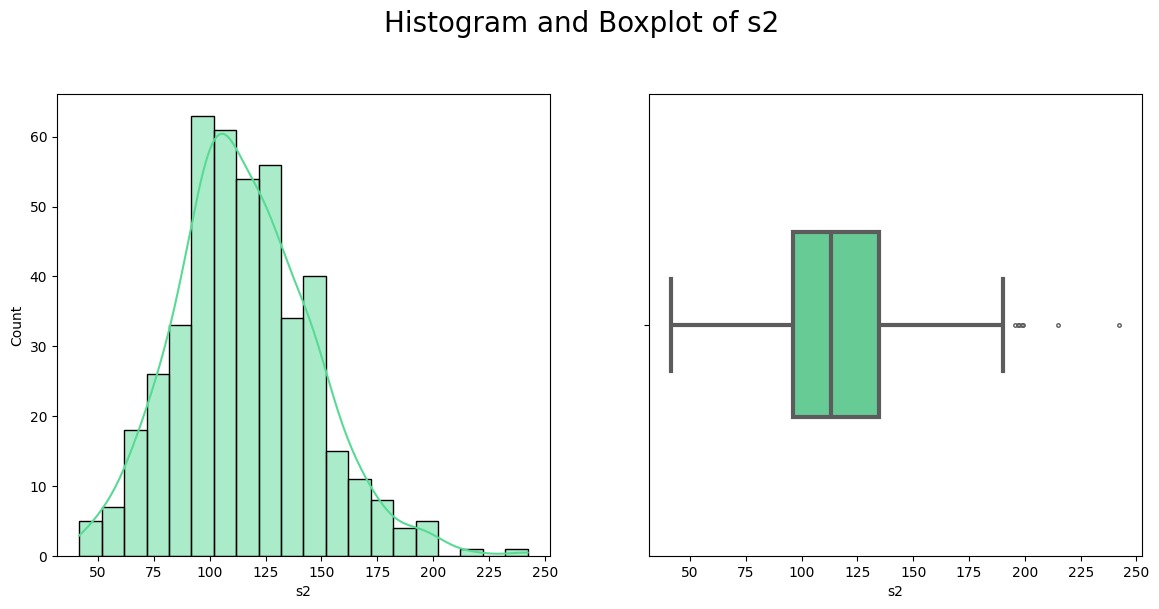

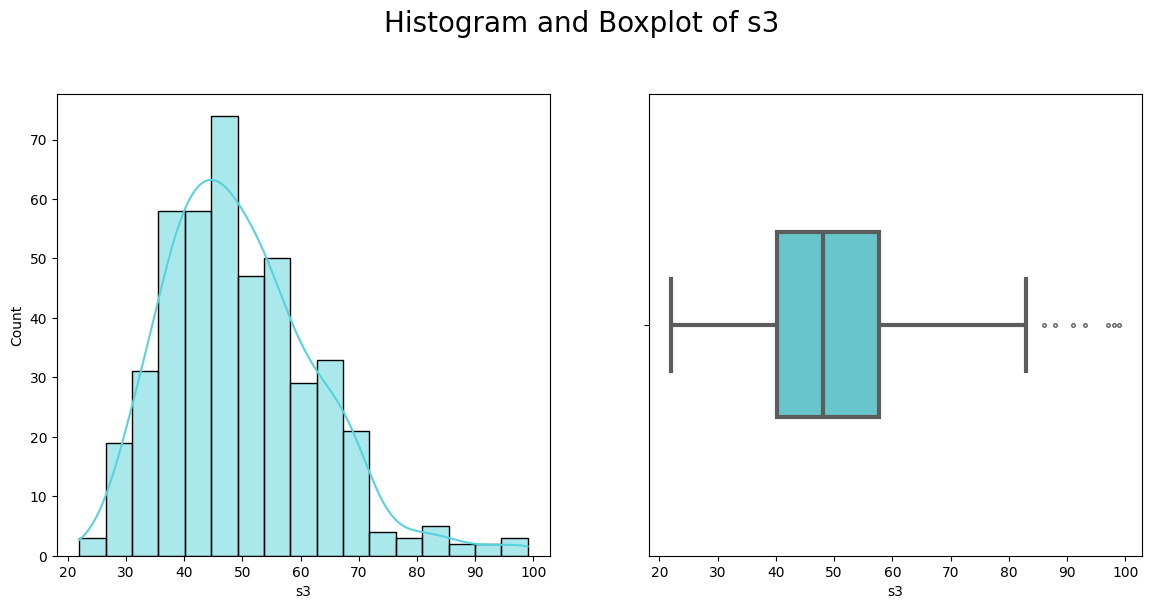

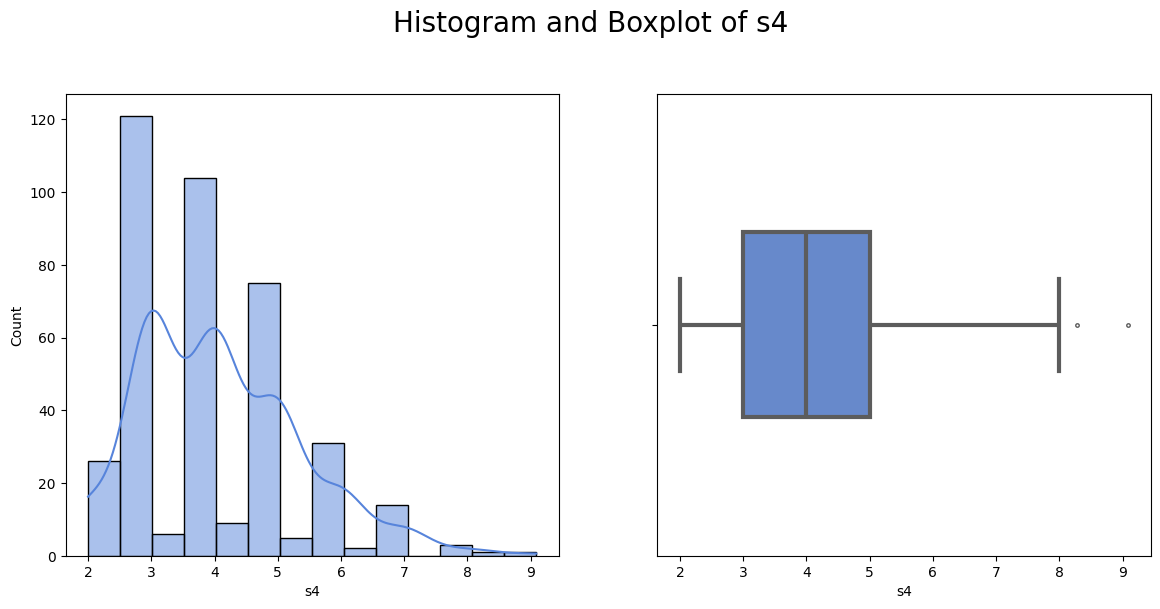

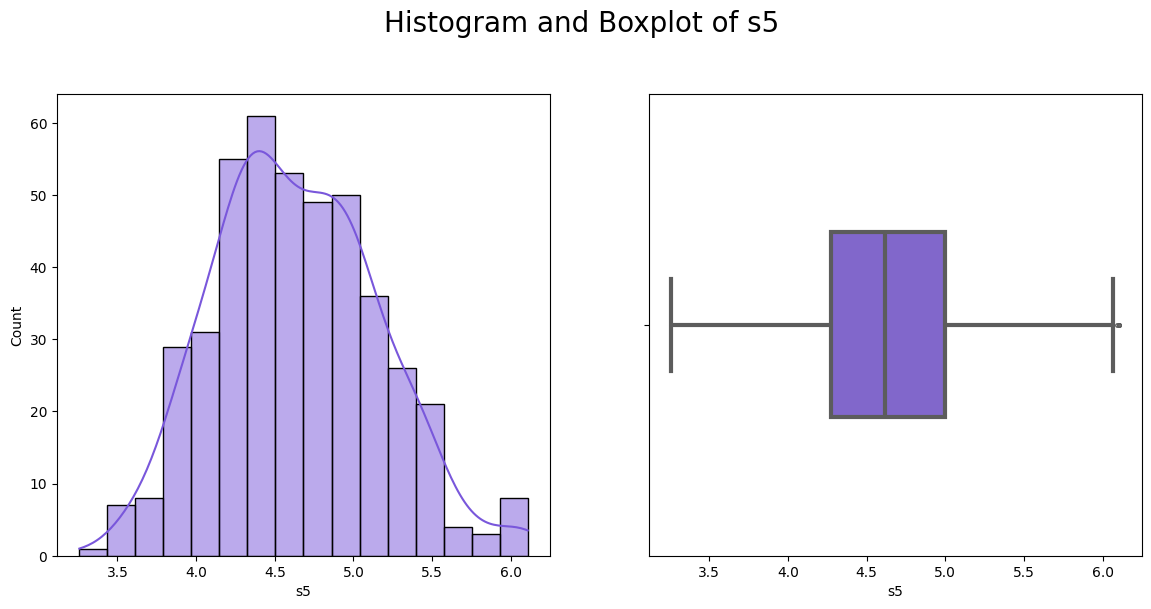

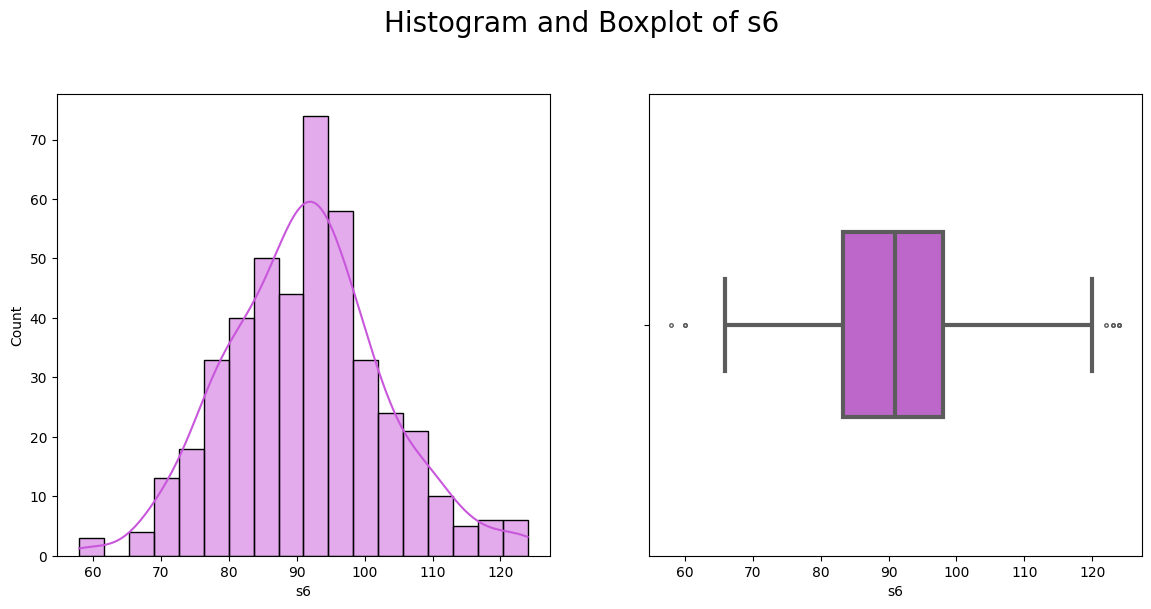

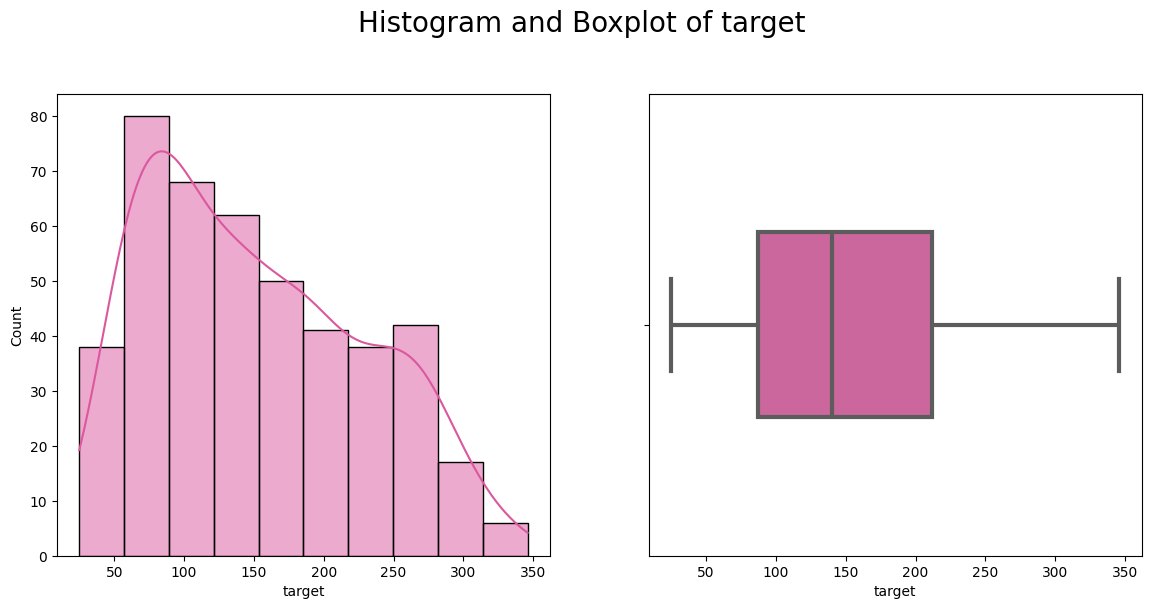

In [30]:
from seaborn import histplot, boxplot

color_palette = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))
 #loop iterate through each column in df except sex1
for idx, col in enumerate([i for i in diabetes.columns if i != 'sex1']):
    #set up subplots
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

    #histogram
    sns.histplot(diabetes, x=diabetes[col], kde = True,color = color_palette[idx],ax=ax1)
    #boxplot
    sns.boxplot(x=diabetes[col],width = 0.4,linewidth = 3,fliersize=2.5,color = color_palette[idx],ax=ax2)

    fig.suptitle(f"Histogram and Boxplot of {col}", size=20, y=1.02)
    plt.show()


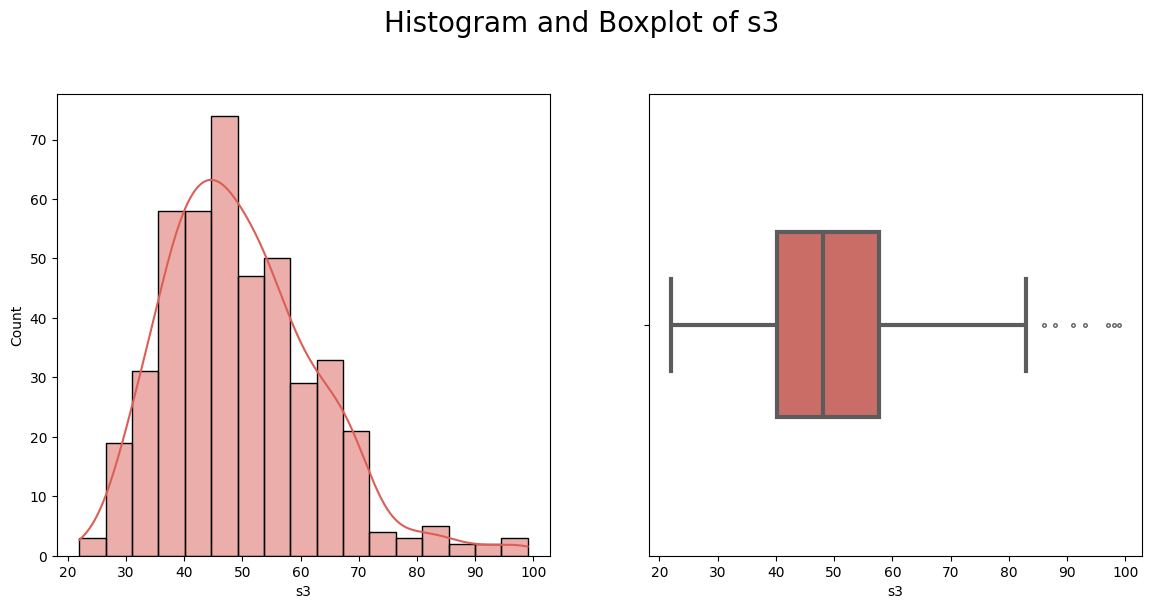

In [31]:
for idx, col in enumerate(['s3']):
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
  sns.histplot(diabetes,x=diabetes[col],kde=True,color=sns.color_palette("hls",len(['s3']))[idx],ax=ax1)
  sns.boxplot(x=diabetes[col],width=0.4,linewidth=3,fliersize=2.5,color=sns.color_palette("hls",len(['s3']))[idx],ax=ax2)
  fig.suptitle(f"Histogram and Boxplot of {col}",size=20,y=1.02)
  plt.show()


#Normality test of s3

In [32]:
stat , p = shapiro(x_train['s3'])
print("stat = %.3f, p=%.3f"%(stat,p))

alpha = 0.05
if p > alpha:
  print("Sample looks normally distributed (fail to reject H0)")
else:
  print("Sample does not look normally distributed (reject H0)")

stat = 0.962, p=0.000
Sample does not look normally distributed (reject H0)


In [33]:
stat, p = shapiro(np.log(x_train['s3']))
print("stat = %.3f, p=%.3f"%(stat,p))
if p > alpha:
  print("Sample looks normally distributed (fail to reject H0)")
else:
  print("Sample does not look normally distributed (reject H0)")

stat = 0.996, p=0.700
Sample looks normally distributed (fail to reject H0)


In [34]:

x_train['s3'] = np.log(x_train['s3'])
x_test['s3'] = np.log(x_test['s3'])

In [35]:
nonnan_train_index = x_train.index[~x_train.isna().max(axis=1)]
nonnan_test_index = x_test.index[~x_test.isna().max(axis=1)]

In [36]:
print(nonnan_test_index)
print(len(nonnan_test_index))

Index([313, 133, 152, 250, 320,  66,  35, 161, 149, 305,
       ...
       182, 132,  47,  81, 104, 439, 289,   0, 137, 306],
      dtype='int64', length=129)
129


In [37]:
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
imp_median = imp_median.fit(x_train) # calc median for each feature in x_train
imp_median_filled = imp_median.transform(x_train)#fill

reg1 = lr.fit(imp_median_filled, y_train) #train model

pred = reg1.predict(x_test.loc[nonnan_test_index])

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.54182281209479

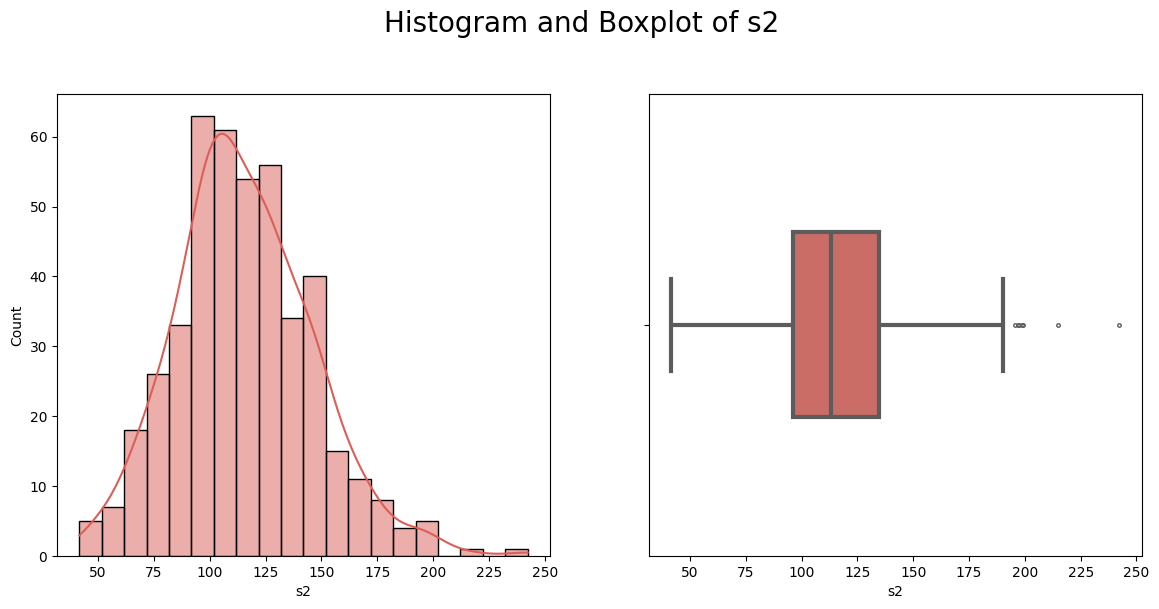

In [38]:
for idx, col in enumerate(['s2']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s2']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s2']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

As we see, we have extreme outlier so we are going to remove

In [39]:
x_train_nonoutlier_idx = x_train.index[x_train.s2<x_train.s2.quantile(0.99)]
x_train_nonoutlier = x_train.loc[x_train_nonoutlier_idx]
y_train_nonoutlier = y_train.loc[x_train_nonoutlier_idx]

In [42]:
nonnan_train_index = x_train_nonoutlier.index[~x_train_nonoutlier.isna().max(axis=1)]
nonnan_test_index = x_test.index[~x_test.isna().max(axis=1)]

imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
imp_median = imp_median.fit(x_train_nonoutlier)
imp_median_filled = imp_median.transform(x_train_nonoutlier)

reg1 = lr.fit(imp_median_filled, y_train_nonoutlier)
pred = reg1.predict(x_test.loc[nonnan_test_index])

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.44650356883508

Colleration Matrix

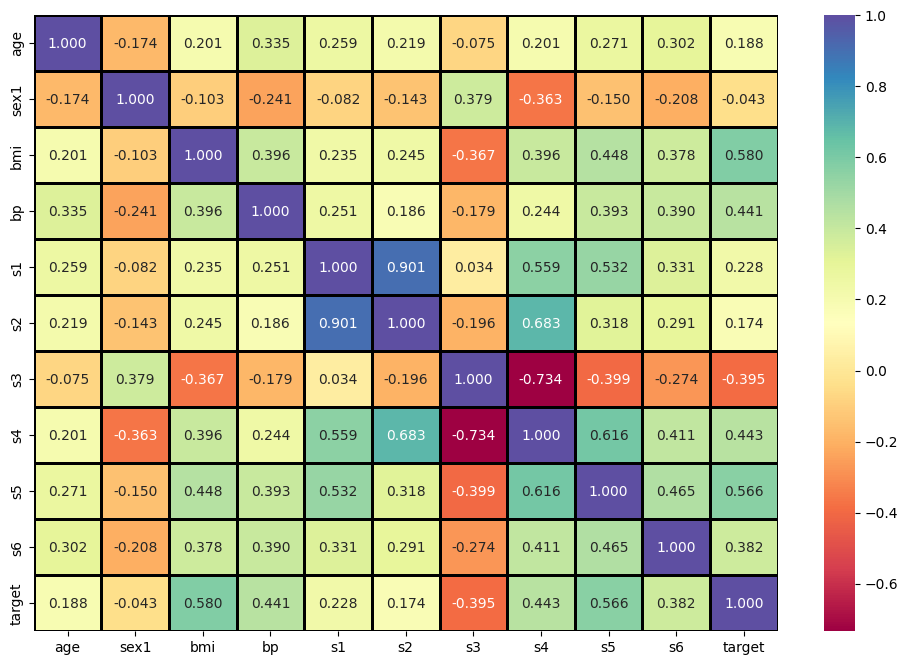

In [48]:
plt.figure(figsize = (12, 8))
sns.heatmap(
    diabetes.corr(), #this compute the colleratio matrix for diabeted dataset
    annot = True, #see value in box
    cmap = "Spectral", #map color palette
    linewidths = 2,
    linecolor = "#000000",
    fmt='.3f')
plt.show()

In [52]:
col_no_s1 = [i for i in x_train.columns if i != 's1']
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
imp_median = imp_median.fit(x_train.loc[:,col_no_s1])
imp_median_filled = imp_median.transform(x_train.loc[:,col_no_s1])

reg1 = lr.fit(imp_median_filled, y_train)
pred = reg1.predict(x_test.loc[nonnan_test_index, col_no_s1])

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)

#worst

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.568398196329426

#Pair Plot

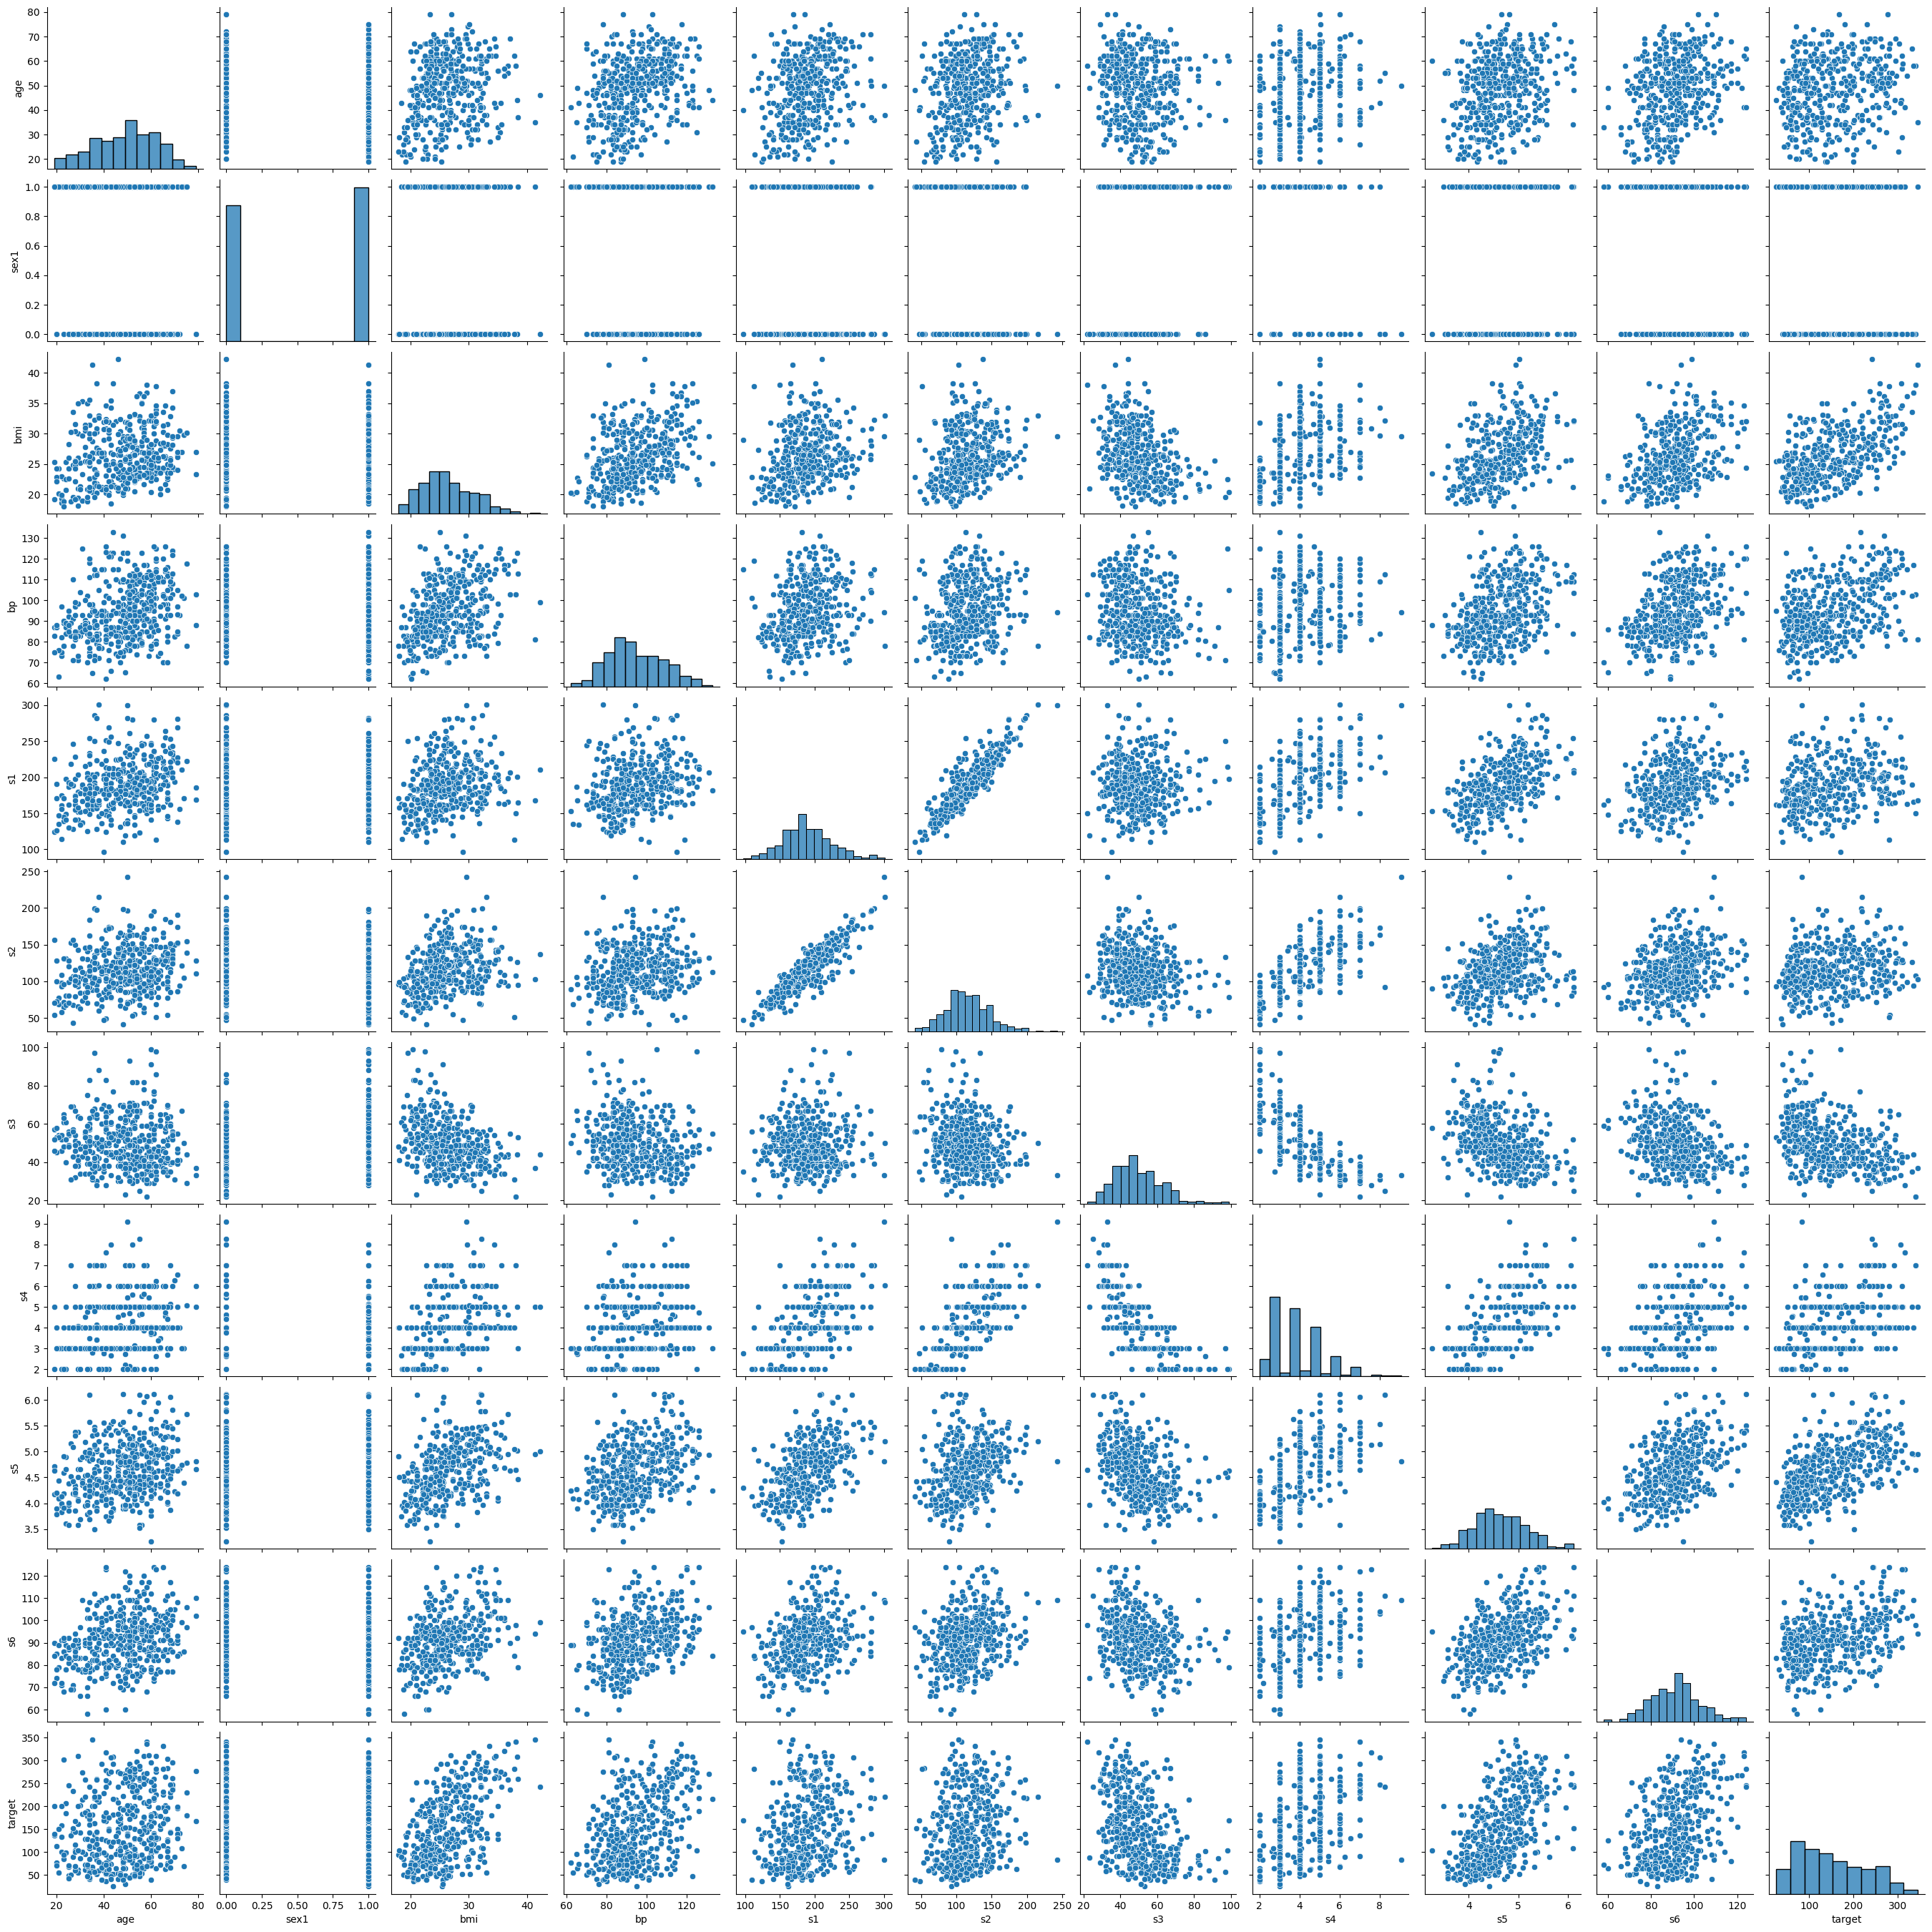

In [53]:
sns.pairplot(diabetes)

DataFrame Head:


age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0

DataFrame Tail:


age  sex1   bmi     bp     s1     s2    s3    s4      s5    s6  target
439  60.0   0.0  24.9  99.67  162.0  106.6  43.0  3.77  4.1271  95.0   132.0
440  36.0   1.0  30.0  95.00  201.0  125.2  42.0  4.79  5.1299  85.0   220.0
441  36.0   1.0  19.6  71.00  250.0  133.2  97.0  3.00  4.5951  92.0    57.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
MSNO Matrix:



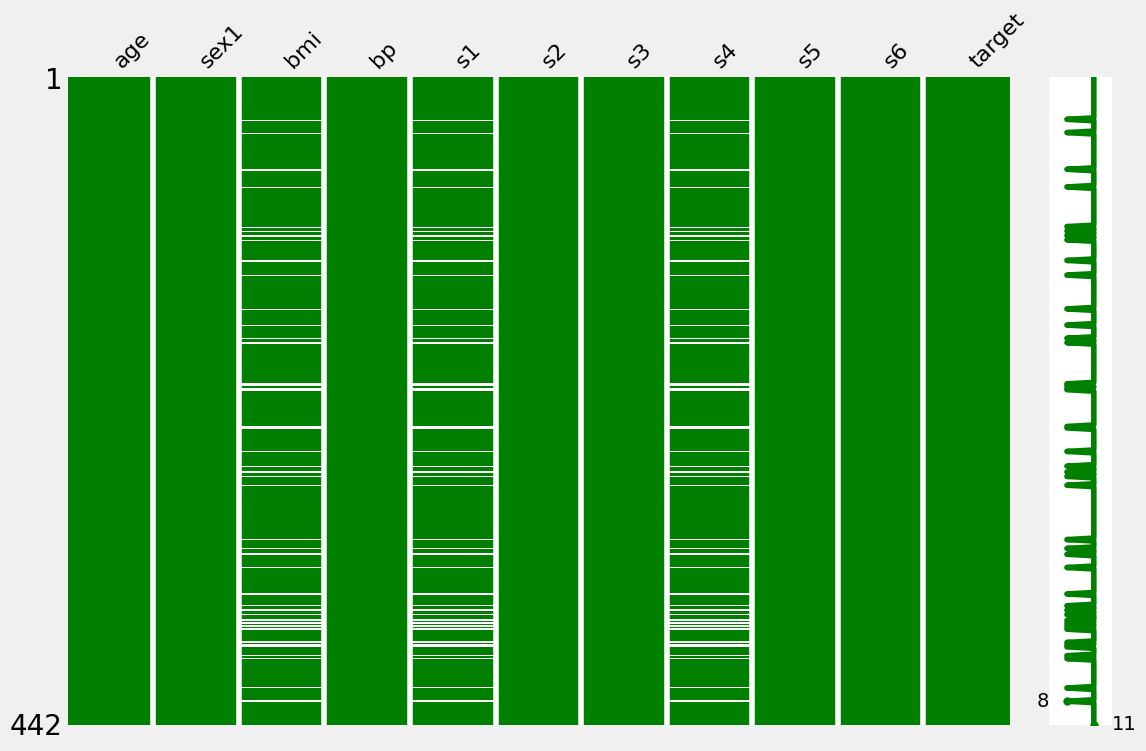

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(442, 11)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex1    442 non-null    float64
 2   bmi     398 non-null    float64
 3   bp      442 non-null    float64
 4   s1      398 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      398 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:


/usr/local/lib/python3.10/dist-packages/fasteda/__init__.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
/usr/local/lib/python3.10/dist-packages/fasteda/__init__.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'age       442
sex1      442
bmi       398
bp        442
s1        398
s2        442
s3        442
s4        398
s5        442
s6        442
target    442
Name: count, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
/usr/local/lib/python3.10/dist-packages/fasteda/__init__.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'age        48.518
sex1        0.532
bmi        

----------------------------------------------------------------------------------------------------
DataFrame Correlation:



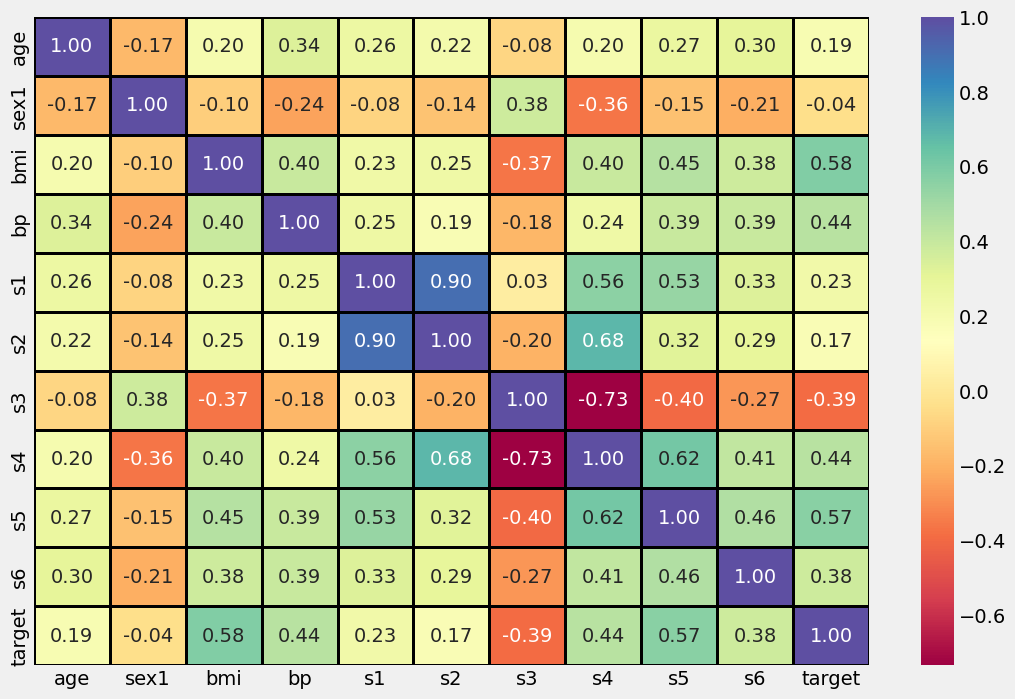

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



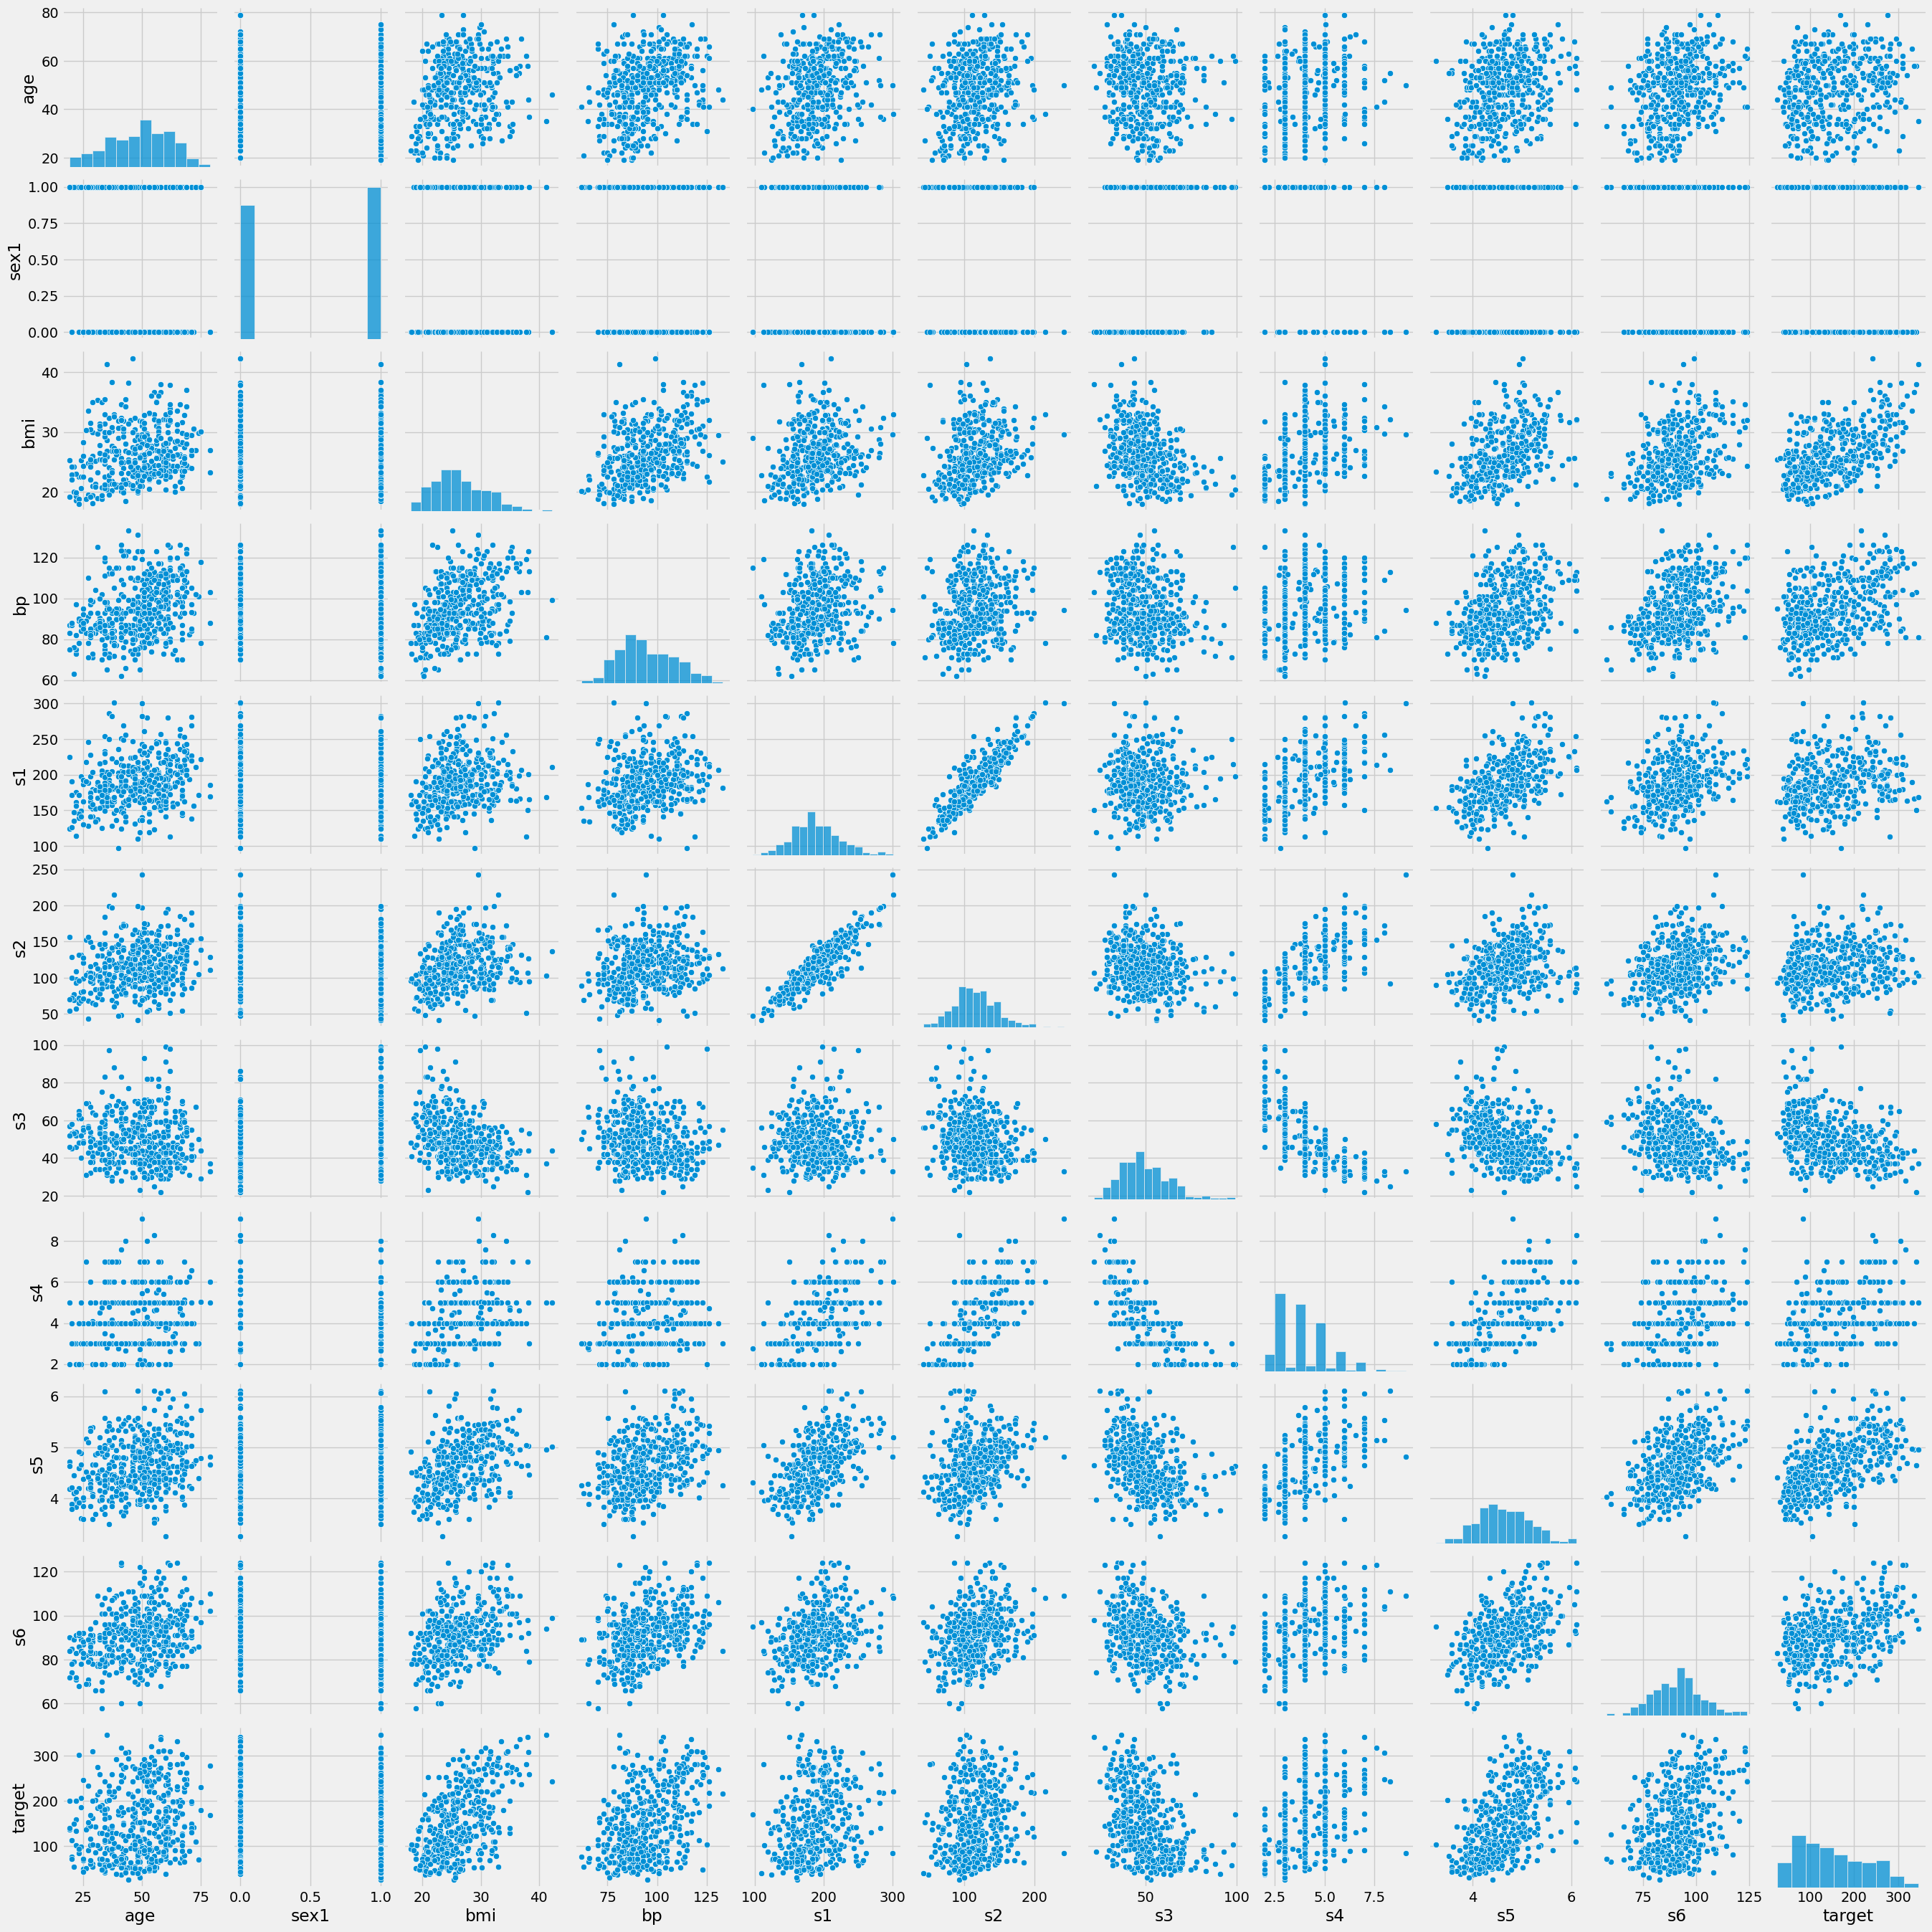

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



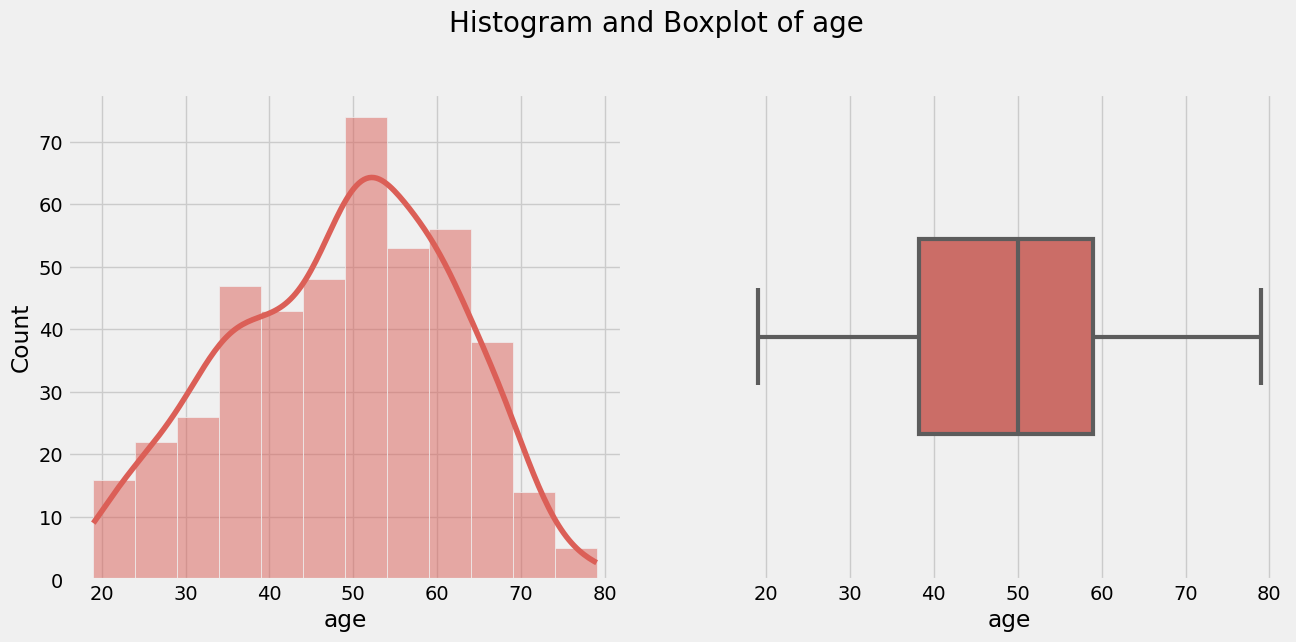

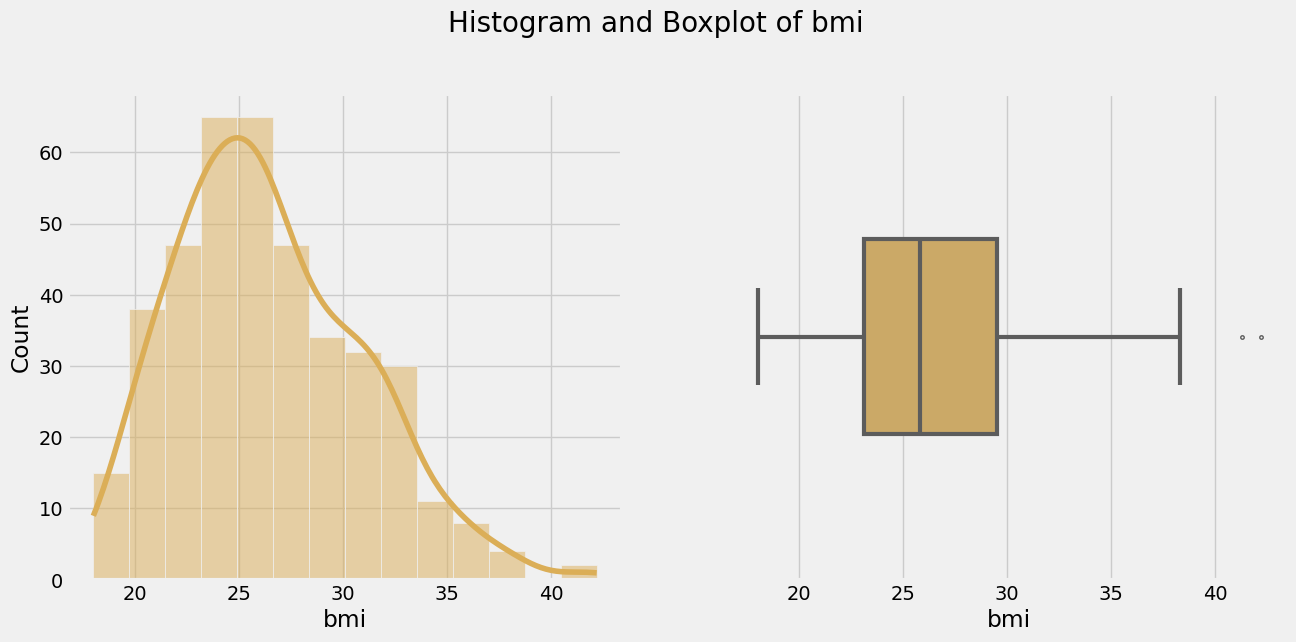

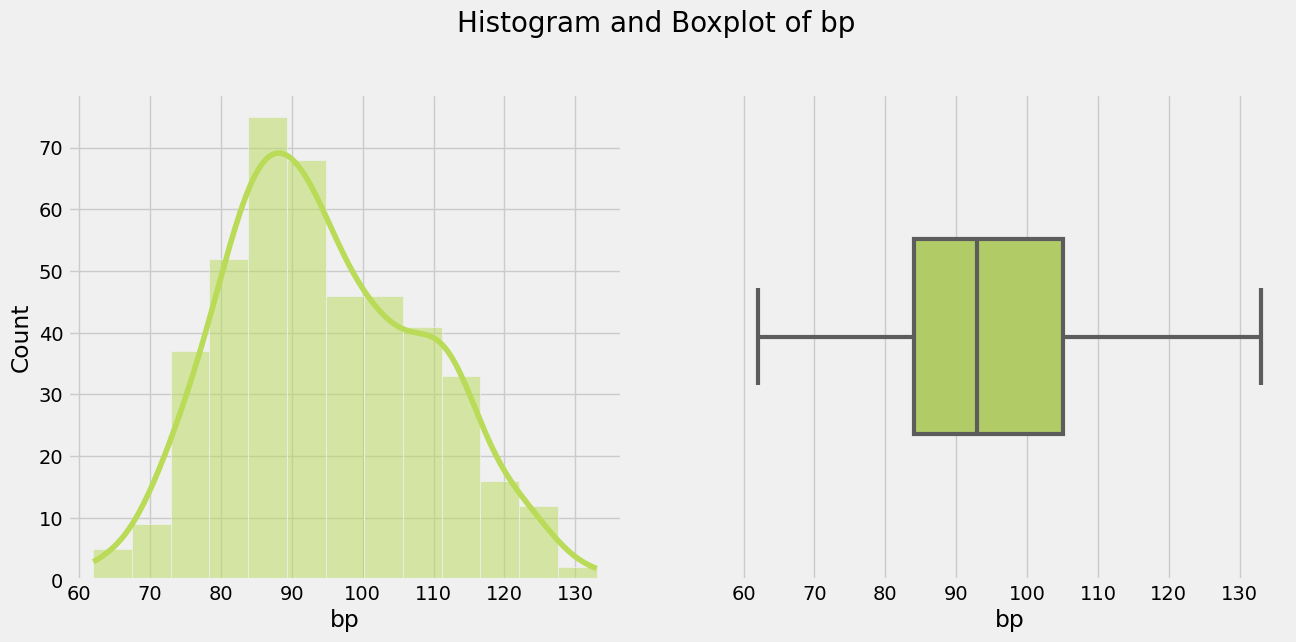

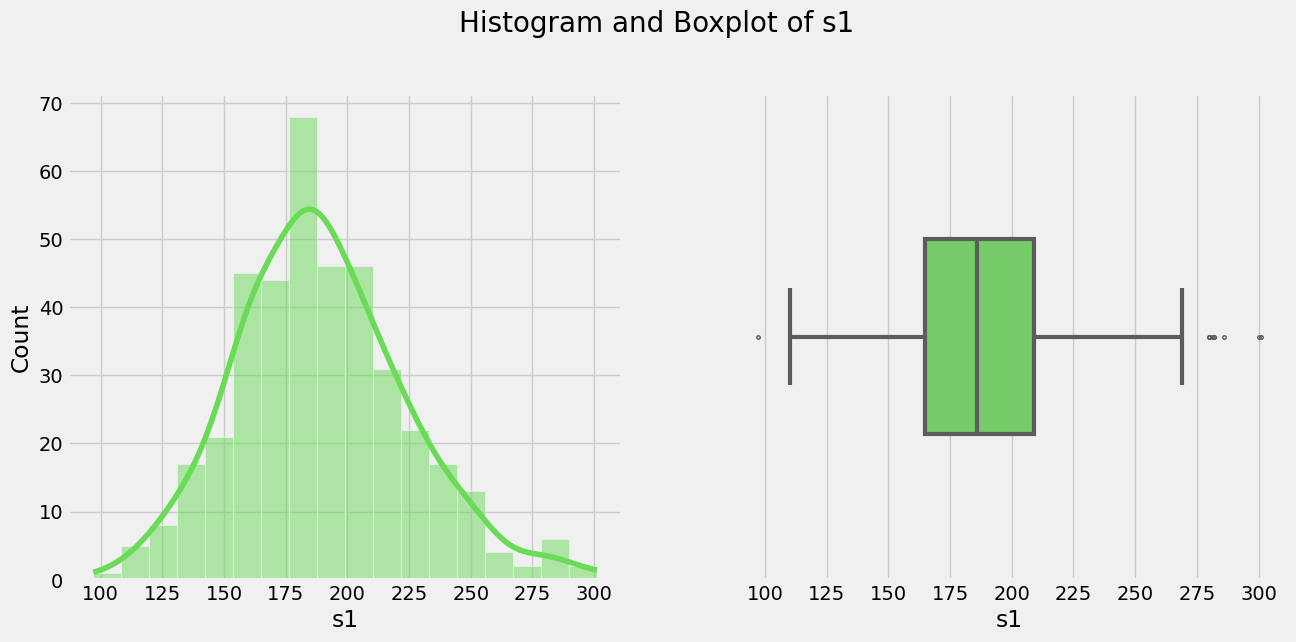

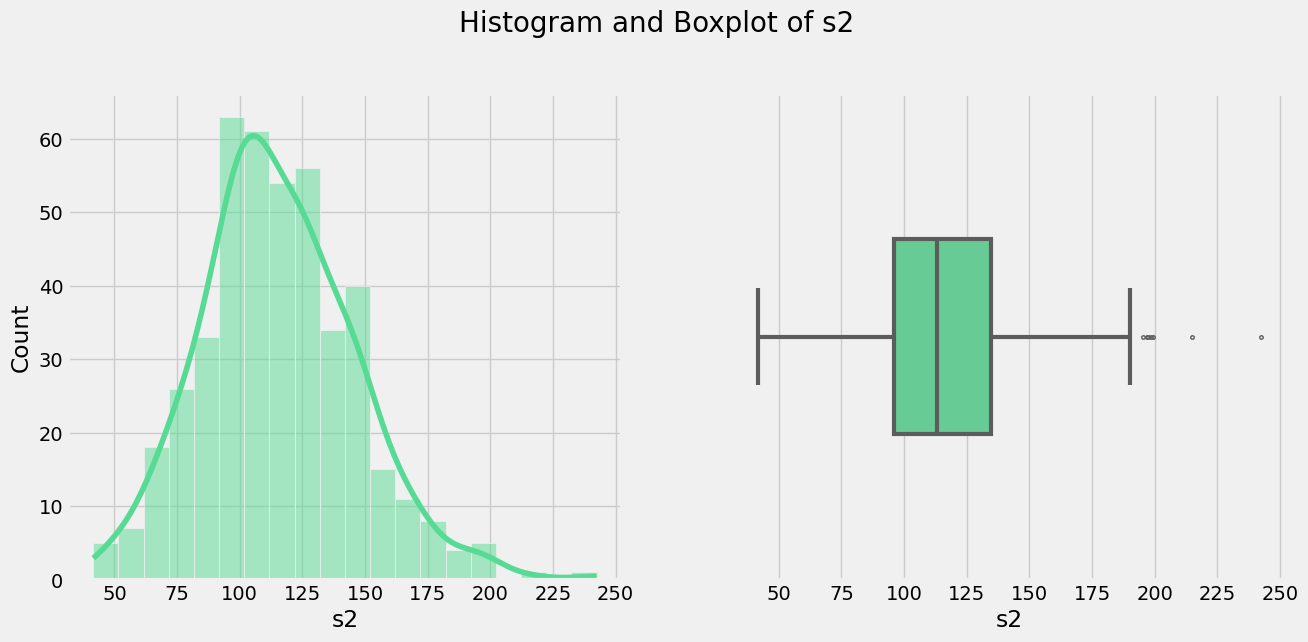

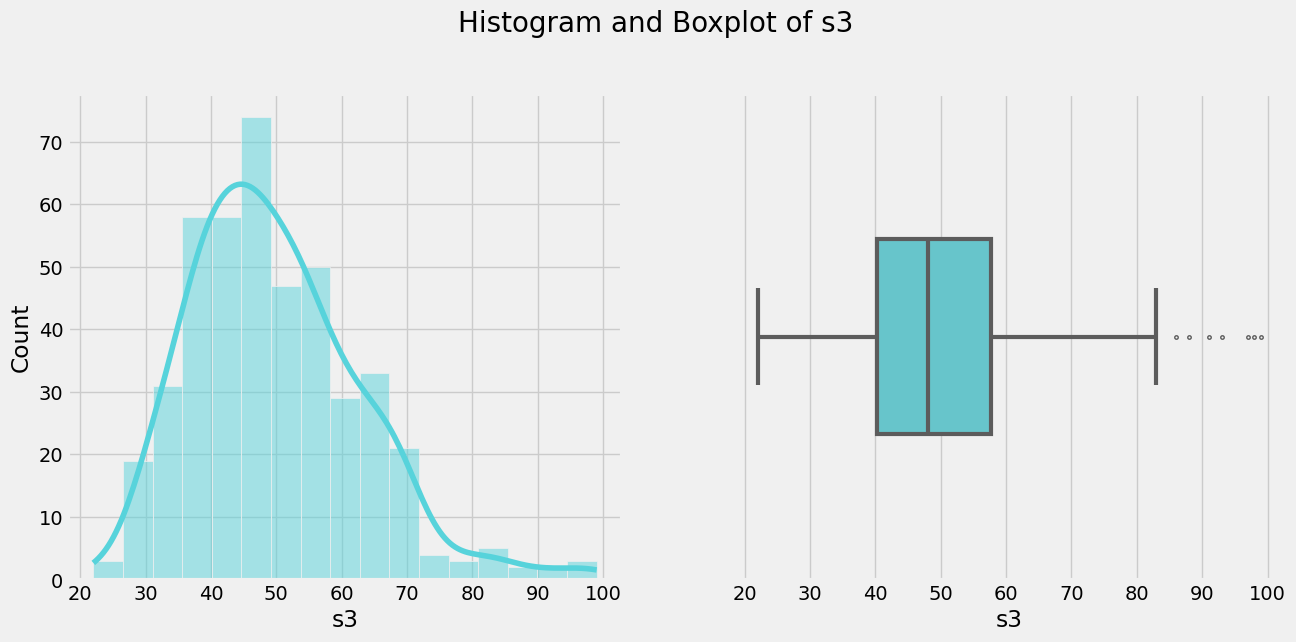

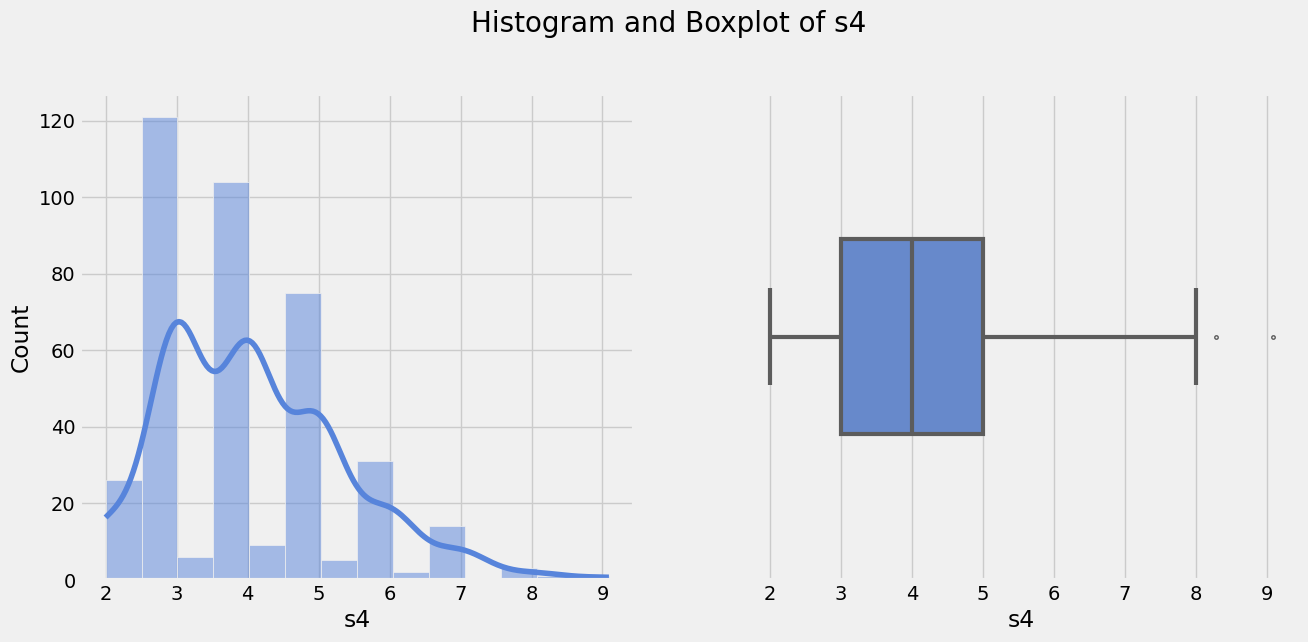

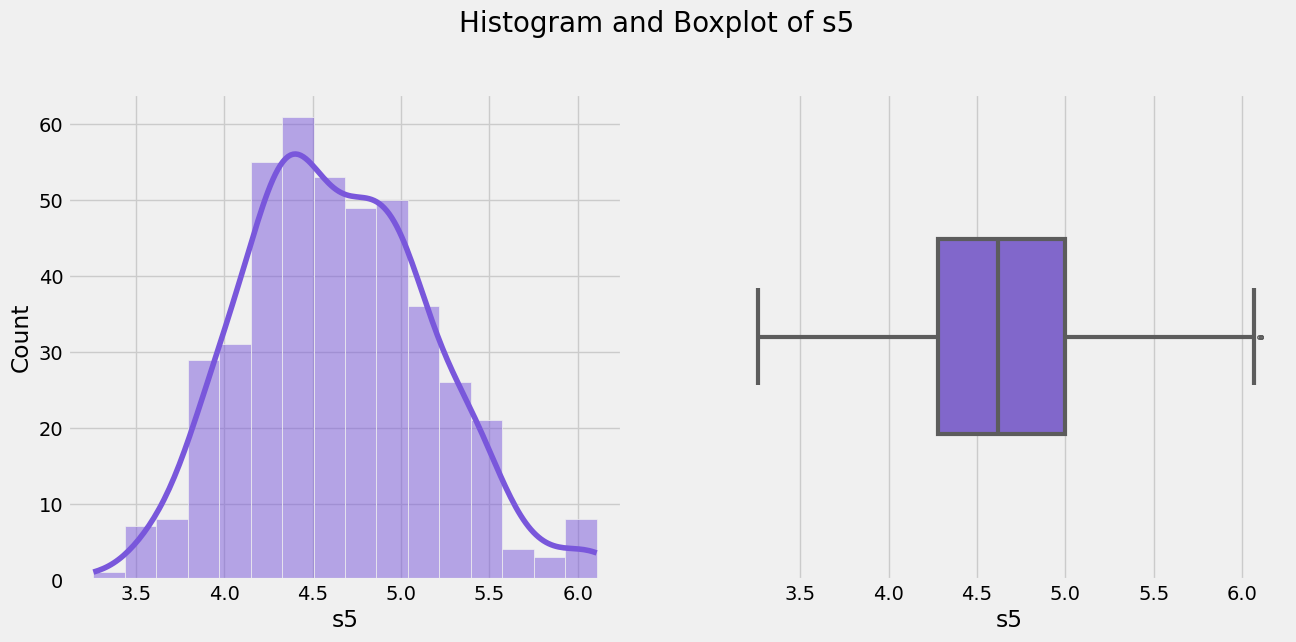

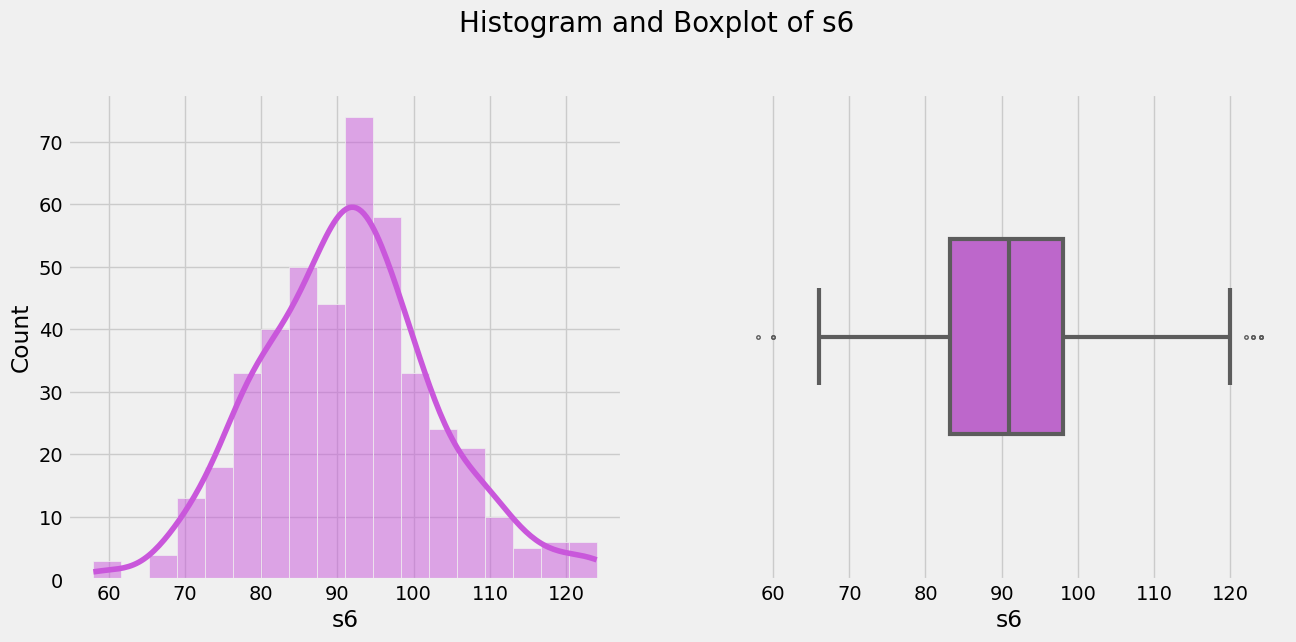

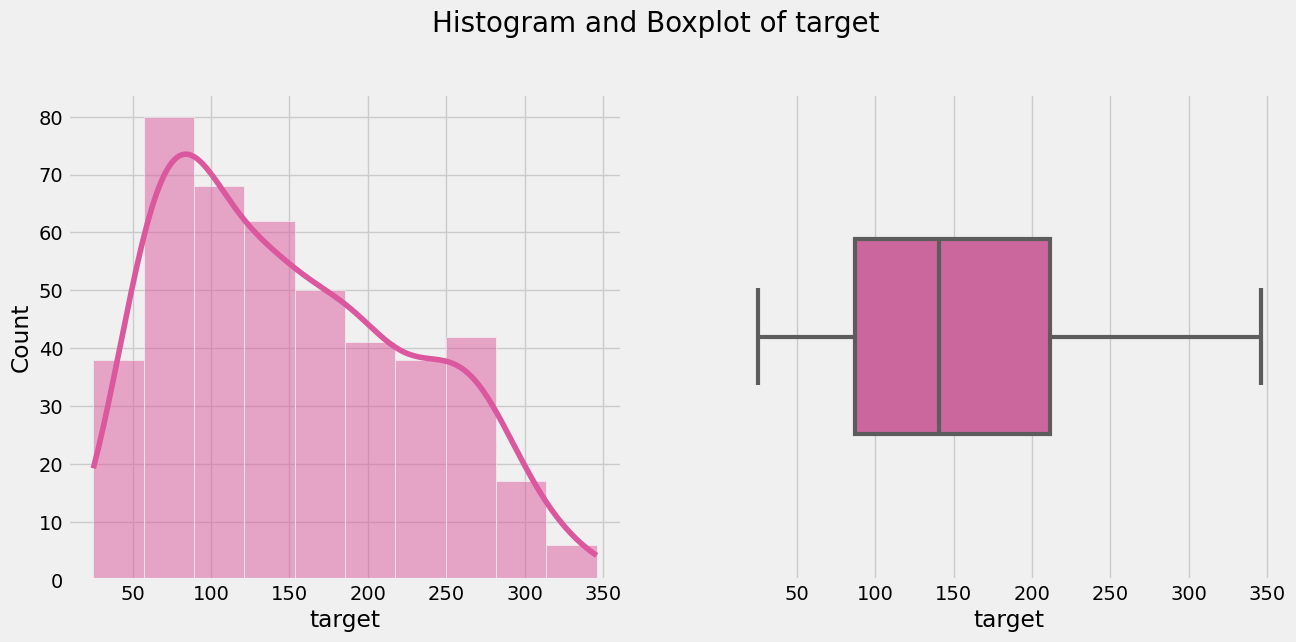

----------------------------------------------------------------------------------------------------
Countplot(s):



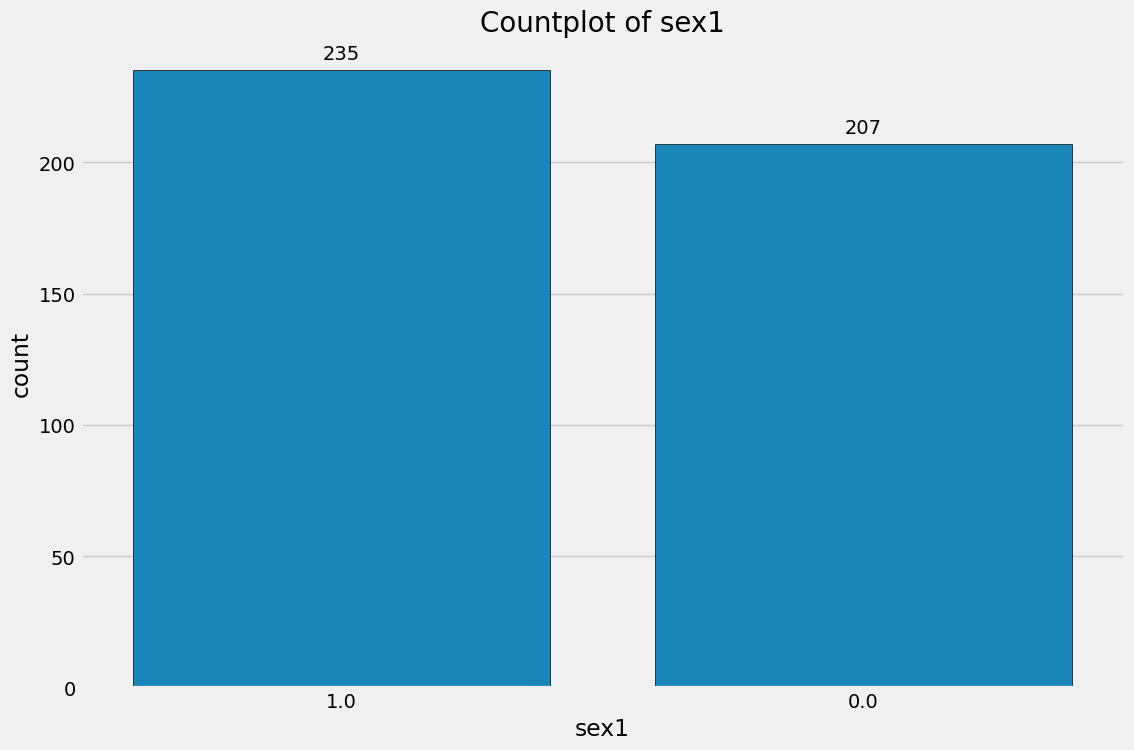

In [55]:
from fasteda import fast_eda


fast_eda(diabetes)


#Classification

In [58]:
iris_sklearn = load_iris()
iris_npy = np.concatenate([iris_sklearn['data'], np.atleast_2d(iris_sklearn['target']).T], axis = 1)


col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

iris = pd.DataFrame(iris_npy, columns=col_names)

print(iris_sklearn['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [59]:
iris['target'].sample(5)

77     1.0
106    2.0
119    2.0
43     0.0
46     0.0
Name: target, dtype: float64

In [61]:
class_names=dict(zip(list(map(float,range(len(iris_sklearn['target_names'])))), iris_sklearn['target_names']))

print(class_names)

{0.0: 'setosa', 1.0: 'versicolor', 2.0: 'virginica'}


DataFrame Head:


sepal_length  sepal_width  petal_length  petal_width  target
0           5.1          3.5           1.4          0.2     0.0
1           4.9          3.0           1.4          0.2     0.0
2           4.7          3.2           1.3          0.2     0.0

DataFrame Tail:


sepal_length  sepal_width  petal_length  petal_width  target
147           6.5          3.0           5.2          2.0     2.0
148           6.2          3.4           5.4          2.3     2.0
149           5.9          3.0           5.1          1.8     2.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(150, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



/usr/local/lib/python3.10/dist-packages/fasteda/__init__.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
/usr/local/lib/python3.10/dist-packages/fasteda/__init__.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sepal_length    150
sepal_width     150
petal_length    150
petal_width     150
target          150
Name: count, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
/usr/local/lib/python3.10/dist-packages/fasteda/__init__.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sepal_length    5.843
sepal_width     3.057
petal_length    3.758
petal_width     1.199
target       

----------------------------------------------------------------------------------------------------
DataFrame Correlation:



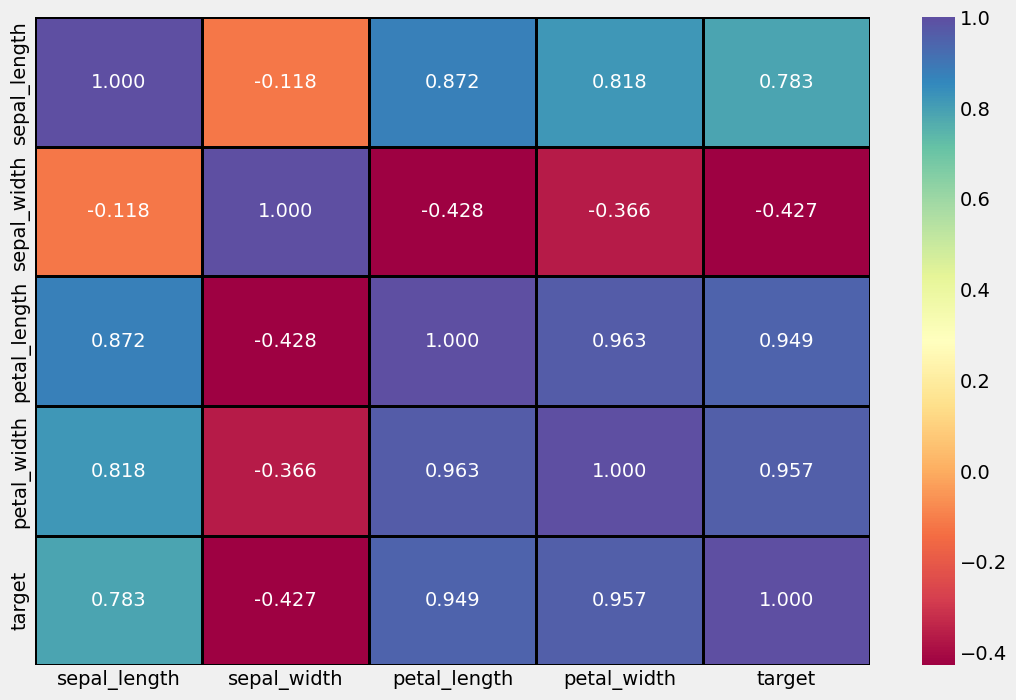

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



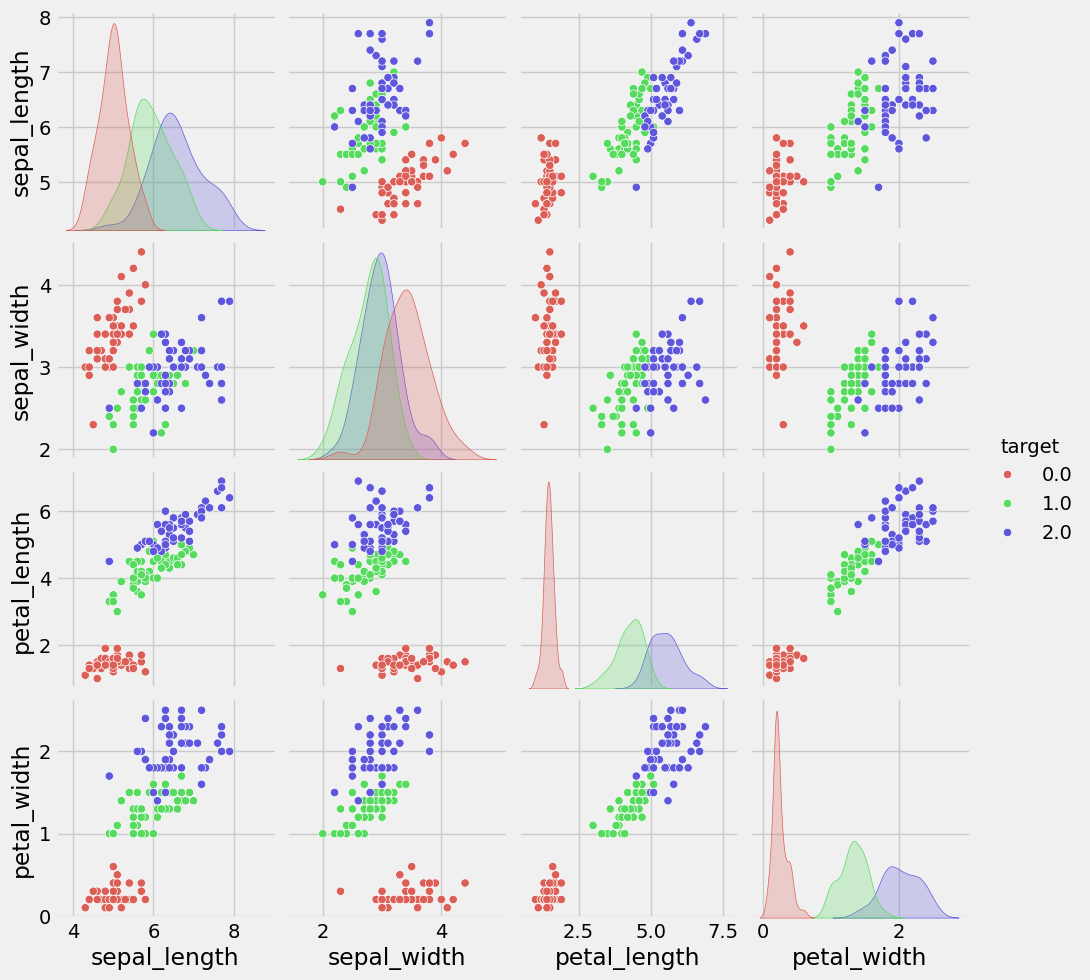

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



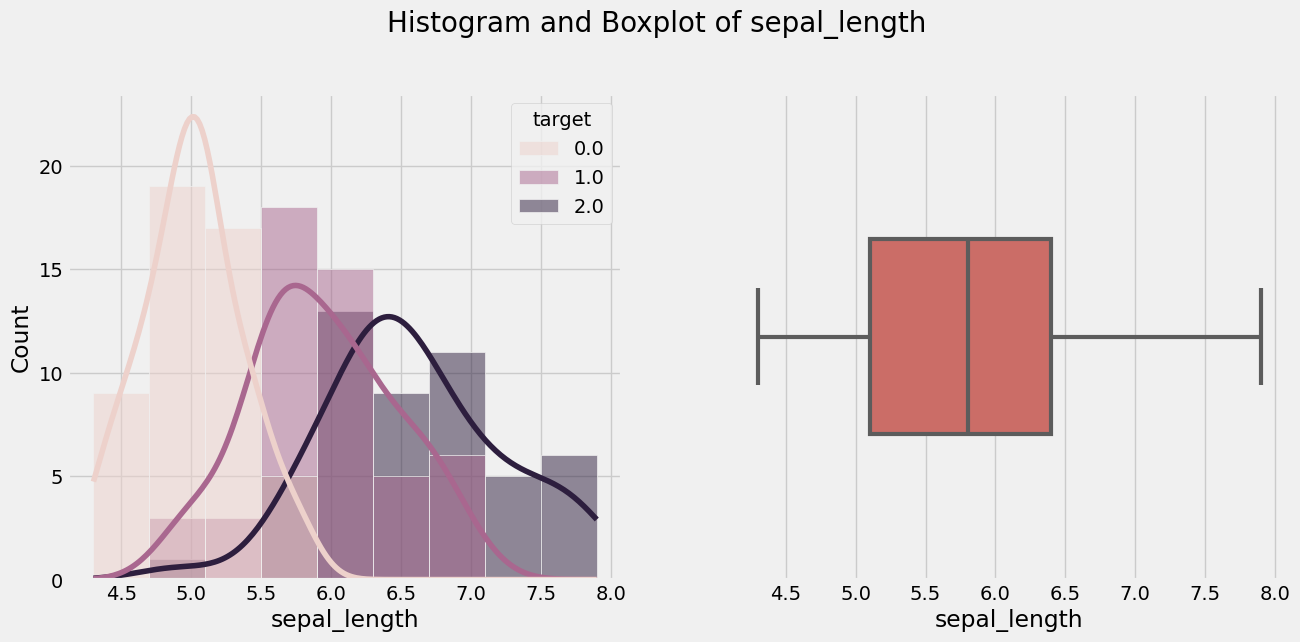

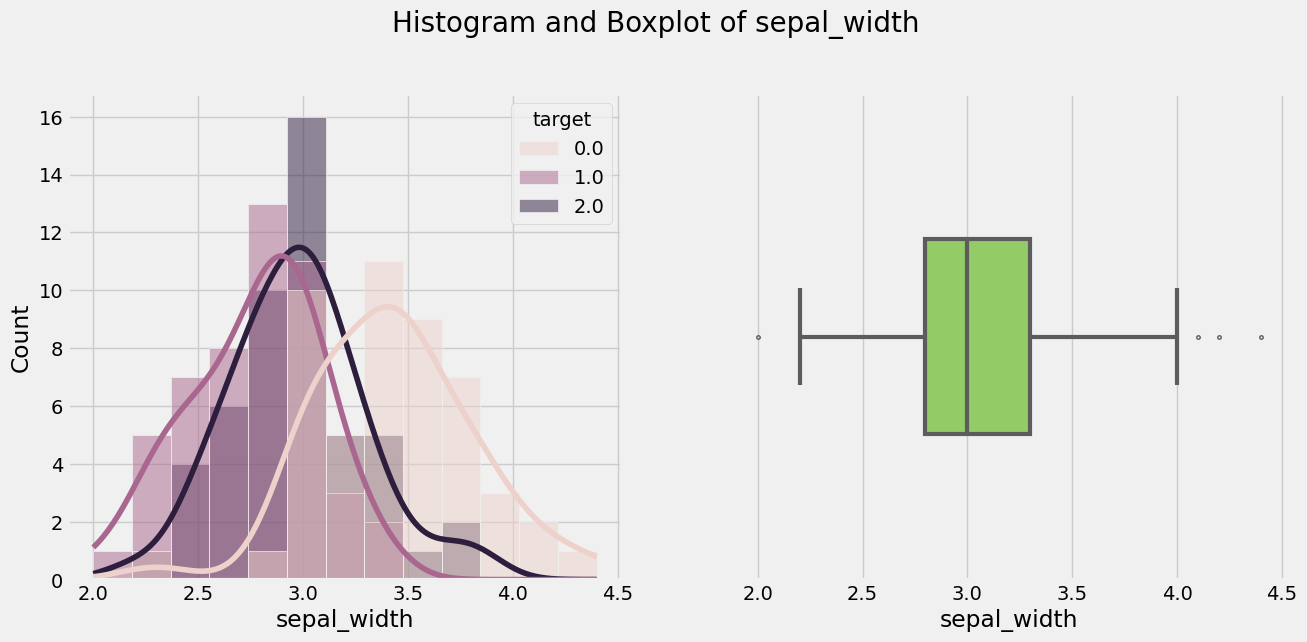

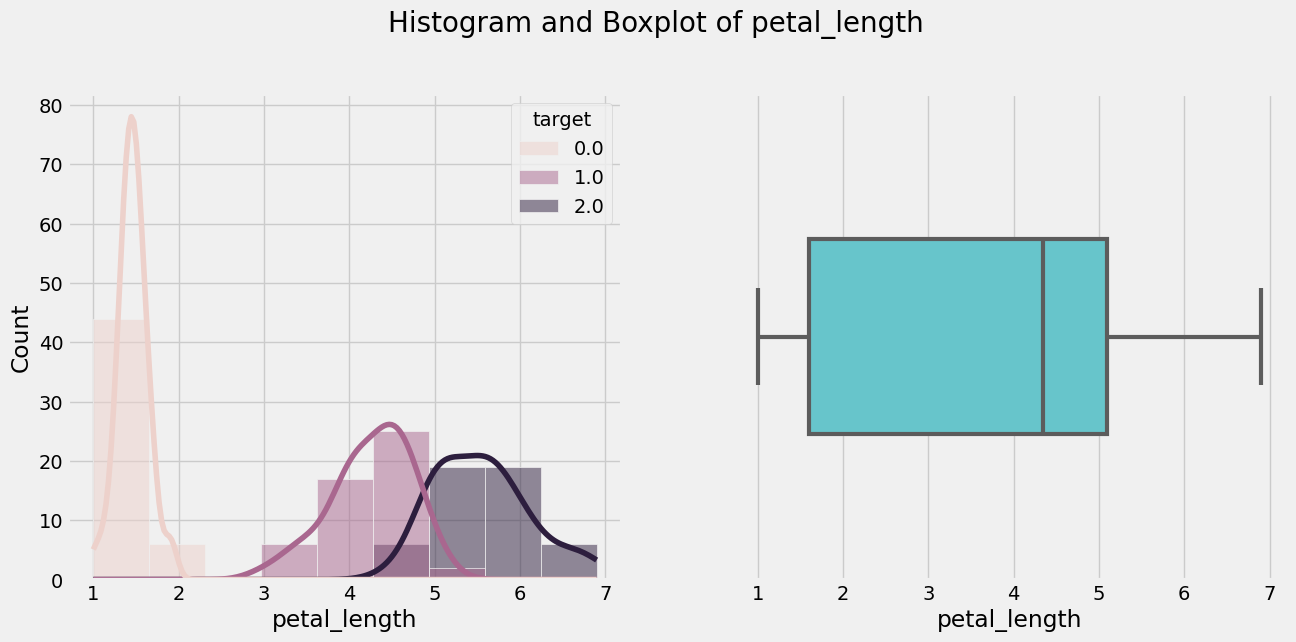

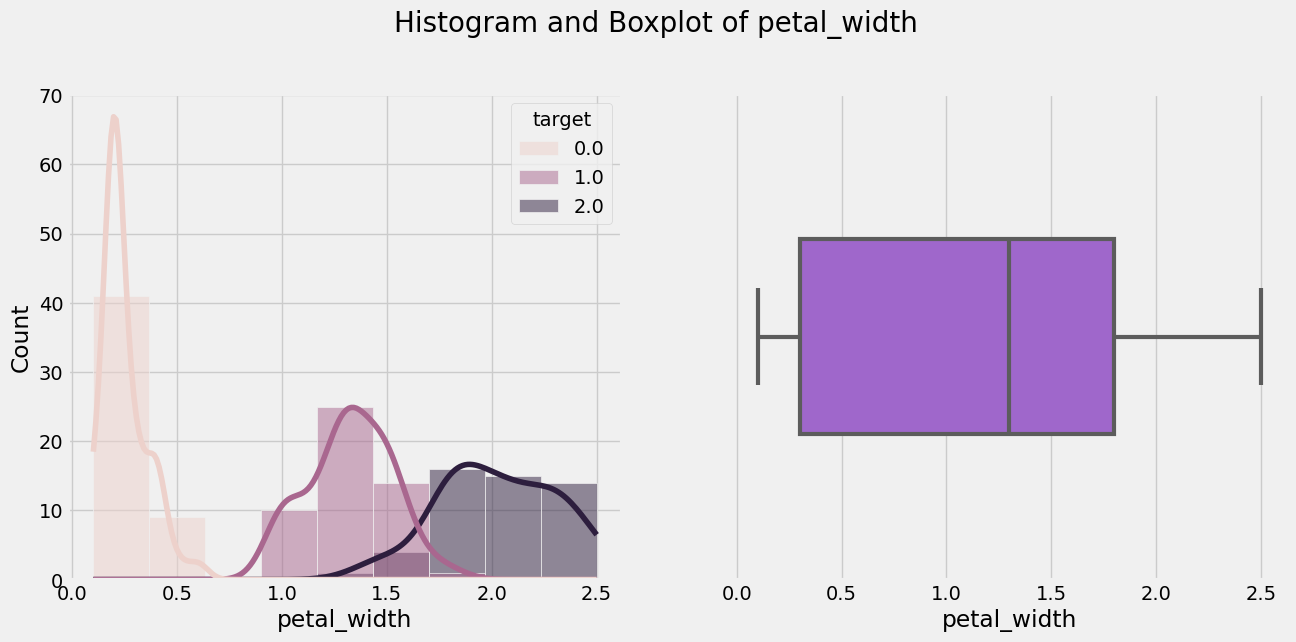

----------------------------------------------------------------------------------------------------
Countplot(s):



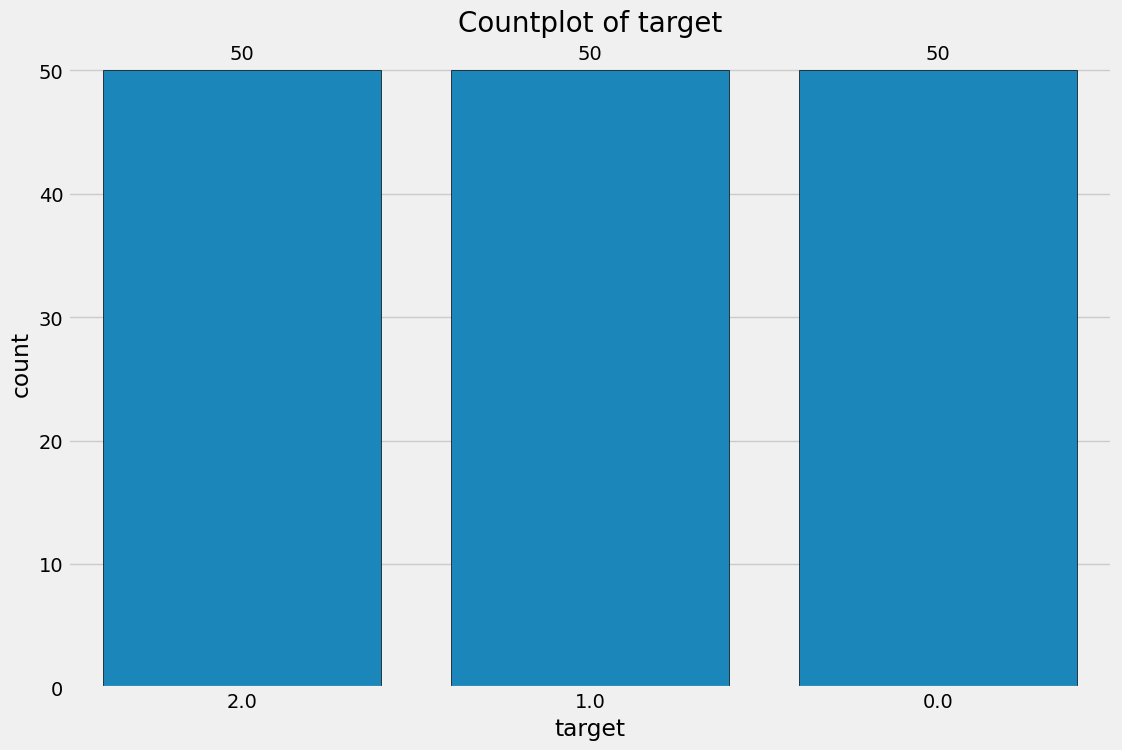

In [62]:
#EDA

fast_eda(iris,target='target')

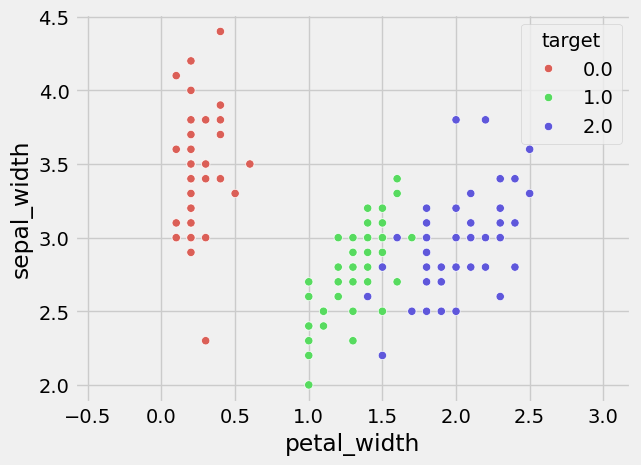

In [65]:
plt.axis('equal')
sns.scatterplot(iris,
                x='petal_width',
                y='sepal_width',
                hue='target',
                palette=sns.color_palette("hls", iris['target'].nunique()))
plt.show()

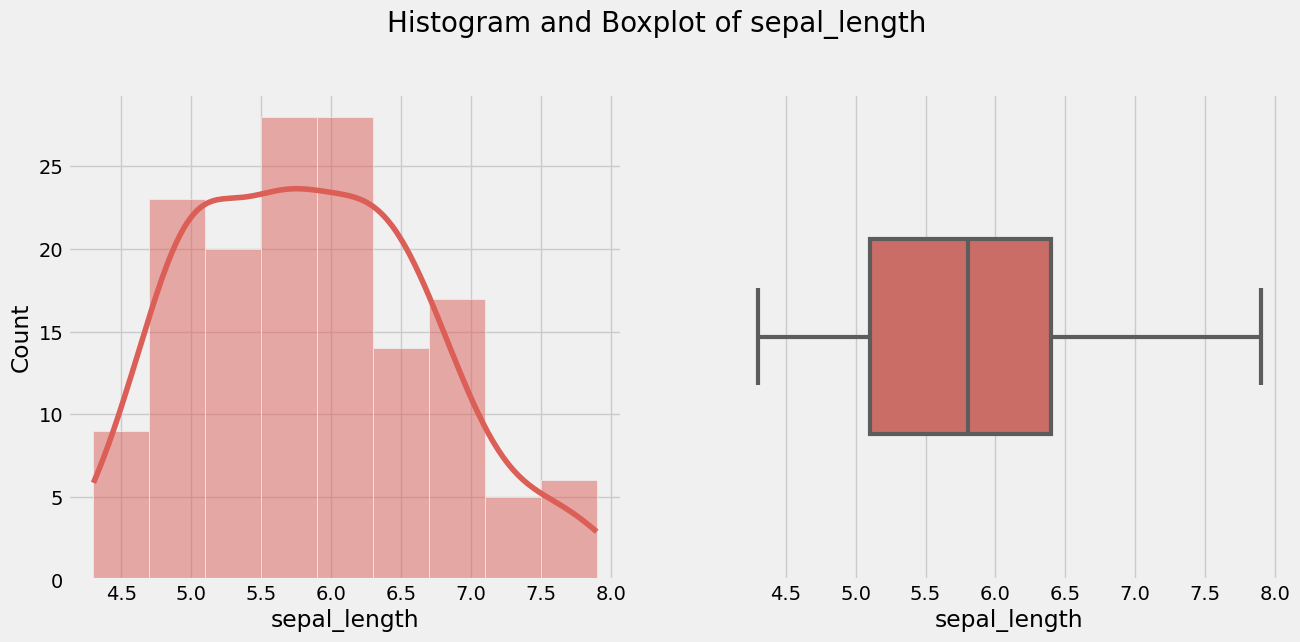

In [67]:
for idx,col in enumerate(['sepal_length']):
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
  sns.histplot(iris,x=iris[col], kde=True,color=sns.color_palette("hls",len(iris['target'].unique()))[idx],ax=ax1)
  sns.boxplot(x=iris[col],width=0.4,linewidth=3,fliersize=2.5,color=sns.color_palette("hls",len(iris['target'].unique()))[idx],ax=ax2)
  fig.suptitle(f"Histogram and Boxplot of {col}",size=20,y=1.02)
  plt.show()

In [68]:
vc = iris['target'].value_counts()
print(vc)

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64
